In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
import torch 
import torch.nn as nn
import torch.optim as optim

In [4]:
from face_emotion_classifier.trainer import Trainer
from face_emotion_classifier.models import FERClassifier

from face_emotion_classifier.utils import *

# Data

## Data Load

In [5]:
df = pd.read_csv('./Face_Emotion_Detection.csv')
df

new_label   V1   V2   V3   V4   V5   V6   V7   V8   V9  ...  V1287  \
0             0  160  179  197  163  132  138  140  154  152  ...    137   
1             3    4    0    2    6   41   57   83   94  113  ...    154   
2             1   92   73   94   74   70   50   78   94   72  ...    196   
3             1   65   67  137  175  185  176  196  204  217  ...    179   
4             0    9   19   29   36   78   99  109  113  120  ...    153   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...   
9459          3   31   20   50   88   83  100  109  113  140  ...     84   
9460          3    8    0   13   10    2   40  128  189  207  ...    151   
9461          3    2    2    0    8    8    8    2   88  202  ...     71   
9462          3   74   55   43   36   36   37   43   38   91  ...     37   
9463          3   27   45   74   92   90   94  105   98   94  ...     90   

      V1288  V1289  V1290  V1291  V1292  V1293  V1294  V1295  V1296  
0       146    171    156    141    124    115    110    128     88  
1       112     22      4      0     22     36     29     33     32  
2       179    199    207    204    198    208    208    197    195  
3        96     42     70    105    142    125     99     92     89  
4       130    118    102     84    104     98    131    145    174  
...     ...    ...    ...    ...    ...    ...    ...    ...    ...  
9459     73     58     30     28     25     40     74     79     85  
9460    146    128    114    107    124    150    139    146    124  
9461     39     30      3      0      0      2      1      1      1  
9462     27     20    143    255    233     89      4     15     17  
9463     88     79     69     52     46     43     62     82    111  

[9464 rows x 1297 columns]

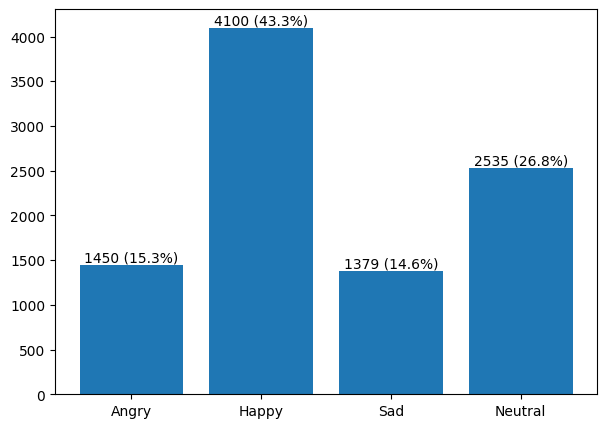

In [6]:
plt.figure(figsize=(7, 5))
class_count = sorted(Counter(df.new_label).items(), key=lambda x: x[0])
total = sum(Counter(df.new_label).values())
x = [c[0] for c in class_count]
y = [c[1] for c in class_count]
plt.bar(x, y)
for x_i, y_i in class_count:
    plt.text(x_i, y_i, f'{y_i} (%.1f%%)' % ((y_i / total) * 100), horizontalalignment='center', verticalalignment='bottom')
plt.xticks(x, labels=CLASS_LABEL.values())
plt.show()

## Plot Sample Image

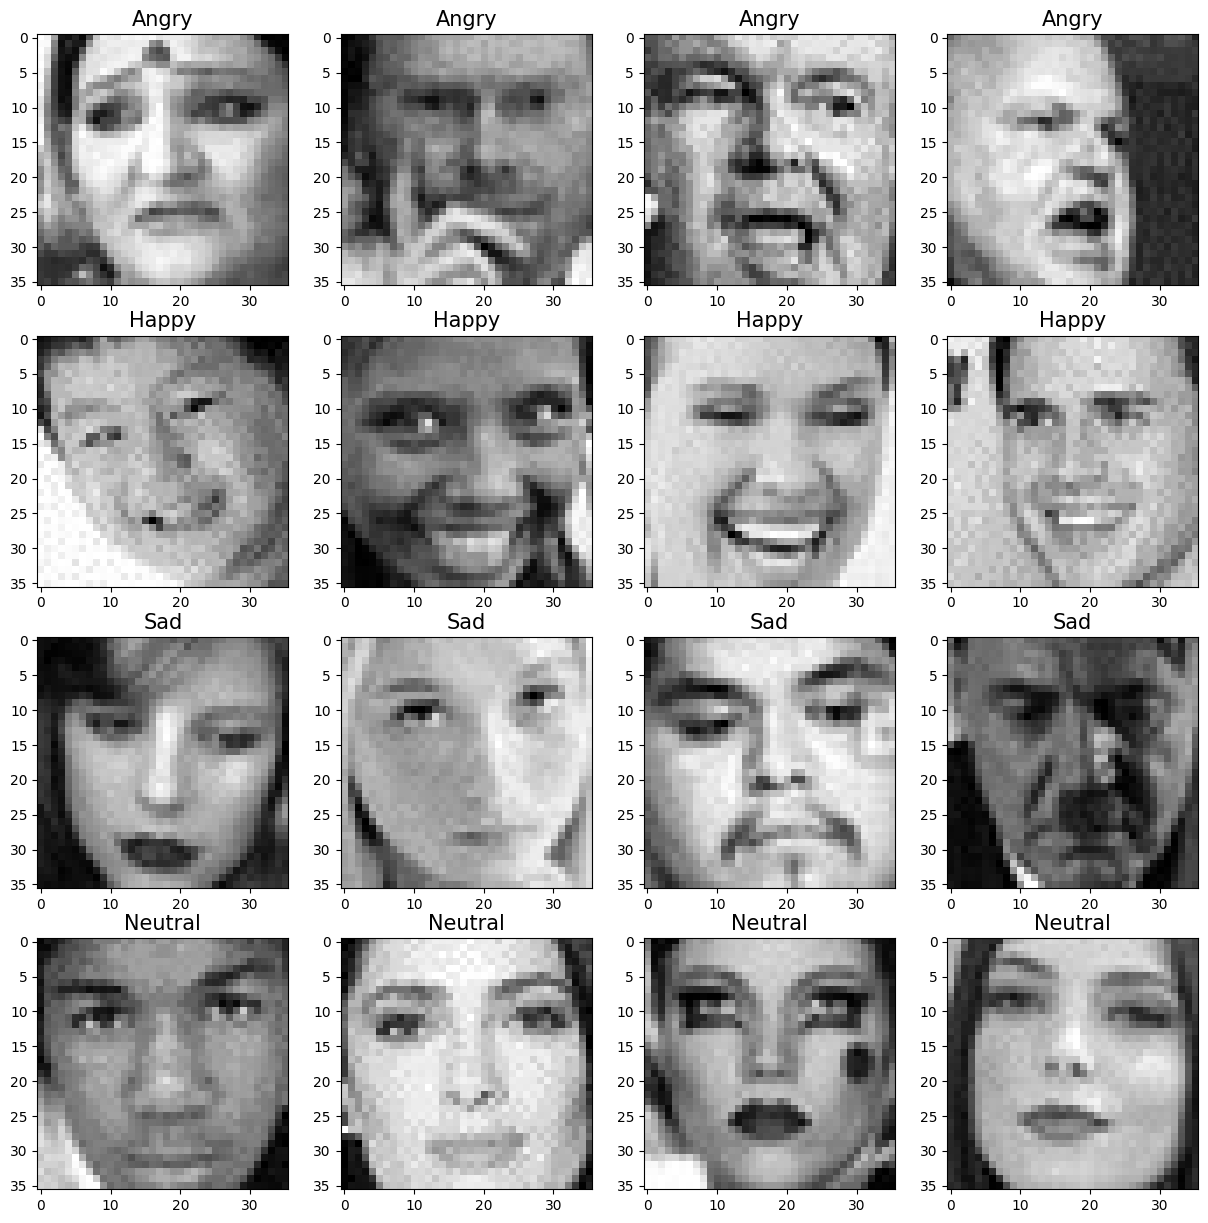

In [7]:
nrows = len(CLASS_LABEL)
ncols = 4

fig, ax = plt.subplots(nrows, ncols, figsize=(15, 15))

for k, v in CLASS_LABEL.items():
    for i, idx in enumerate(np.random.choice(df[df.new_label == k].index.values, ncols)):
        ax[k, i].imshow(df.iloc[idx].values[1:].reshape(36, 36), cmap='gray')
        ax[k, i].set_title(CLASS_LABEL[df.iloc[idx].values[0]], fontsize=15)
        
plt.show()

# Baseline

In [10]:
X = df.values[:, 1:]
y = df.values[:, 0]

In [11]:
print('X Shape:', X.shape)
print('y Shape:', y.shape)

X Shape: (9464, 1296)
y Shape: (9464,)


In [83]:
X_, y_ = preprocessing(
    X, y,
    test_ratio=.2,
    random_state=111,
    o_sampling=None,
    u_sampling=None
)
train_data = (X_[0], y_[0])
test_data = (X_[1], y_[1])

In [84]:
print('X_train Shape:', train_data[0].shape)
print('y_train Shape:', train_data[1].shape)
print('Class Distribution:', dict(sorted(Counter(train_data[1]).items(), key=lambda x:x[0])))
print()
print('X_test Shape:', test_data[0].shape)
print('y_test Shape:', test_data[1].shape)
print('Class Distribution:', dict(sorted(Counter(test_data[1]).items(), key=lambda x:x[0])))

X_train Shape: (7571, 36, 36)
y_train Shape: (7571,)
Class Distribution: {0: 1160, 1: 3280, 2: 1103, 3: 2028}

X_test Shape: (1893, 36, 36)
y_test Shape: (1893,)
Class Distribution: {0: 290, 1: 820, 2: 276, 3: 507}


## XGBOOST

In [12]:
from xgboost import XGBClassifier

In [13]:
xgb = XGBClassifier(
    booster='gbtree', objective='multi:softprob',
    n_estimators=500, random_state=111
)

In [14]:
xgb.fit(
    train_data[0].reshape(-1, 36*36), train_data[1],
    eval_set=[(test_data[0].reshape(-1, 36*36), test_data[1])],
    eval_metric='merror',
    early_stopping_rounds=100, verbose=10
)

[0]	validation_0-merror:0.50238
[10]	validation_0-merror:0.40042
[20]	validation_0-merror:0.39250
[30]	validation_0-merror:0.38457
[40]	validation_0-merror:0.37876
[50]	validation_0-merror:0.37401
[60]	validation_0-merror:0.36978
[70]	validation_0-merror:0.36609
[80]	validation_0-merror:0.36609
[90]	validation_0-merror:0.36450
[100]	validation_0-merror:0.36080
[110]	validation_0-merror:0.36609
[120]	validation_0-merror:0.36926
[130]	validation_0-merror:0.36767
[140]	validation_0-merror:0.36503
[150]	validation_0-merror:0.36820
[160]	validation_0-merror:0.36926
[170]	validation_0-merror:0.36820
[180]	validation_0-merror:0.36503
[190]	validation_0-merror:0.36027
[200]	validation_0-merror:0.36027
[210]	validation_0-merror:0.36133
[220]	validation_0-merror:0.36186
[230]	validation_0-merror:0.35922
[240]	validation_0-merror:0.36133
[250]	validation_0-merror:0.36080
[260]	validation_0-merror:0.36450
[270]	validation_0-merror:0.36133
[280]	validation_0-merror:0.36080
[290]	validation_0-merror

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)


Classification Report
              precision    recall  f1-score   support

           0       0.29      0.54      0.37       154
           1       0.89      0.75      0.81       969
           2       0.17      0.35      0.23       138
           3       0.70      0.56      0.62       632

    accuracy                           0.64      1893
   macro avg       0.51      0.55      0.51      1893
weighted avg       0.72      0.64      0.67      1893



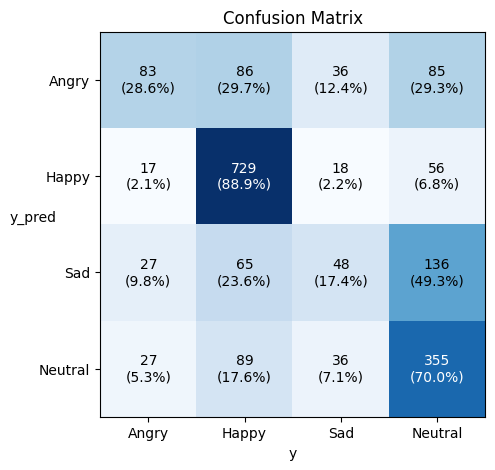

In [15]:
evaluate(
    xgb,
    test_data[0].reshape(-1, 36*36),
    test_data[1],
    is_torch=False
)

## LightGBM

In [16]:
from lightgbm import LGBMClassifier

In [17]:
lgbm = LGBMClassifier(
    objective='cross_entropy'
)

In [18]:
lgbm.fit(
    train_data[0].reshape(-1, 36*36),
    train_data[1],
    eval_set=[(test_data[0].reshape(-1, 36*36), test_data[1])],
    eval_metric='multi_error',
    early_stopping_rounds=10,
    verbose=10
)

[10]	valid_0's multi_error: 0.429477	valid_0's multi_logloss: 1.08221
[20]	valid_0's multi_error: 0.39197	valid_0's multi_logloss: 1.00745
[30]	valid_0's multi_error: 0.37982	valid_0's multi_logloss: 0.97115
[40]	valid_0's multi_error: 0.37084	valid_0's multi_logloss: 0.942981
[50]	valid_0's multi_error: 0.366086	valid_0's multi_logloss: 0.929735
[60]	valid_0's multi_error: 0.363444	valid_0's multi_logloss: 0.920409
[70]	valid_0's multi_error: 0.359746	valid_0's multi_logloss: 0.914779
[80]	valid_0's multi_error: 0.35552	valid_0's multi_logloss: 0.909345
[90]	valid_0's multi_error: 0.35869	valid_0's multi_logloss: 0.910072


LGBMClassifier(objective='cross_entropy')


Classification Report
              precision    recall  f1-score   support

           0       0.28      0.57      0.38       142
           1       0.88      0.73      0.80       989
           2       0.19      0.43      0.26       124
           3       0.72      0.57      0.63       638

    accuracy                           0.64      1893
   macro avg       0.52      0.57      0.52      1893
weighted avg       0.74      0.64      0.68      1893



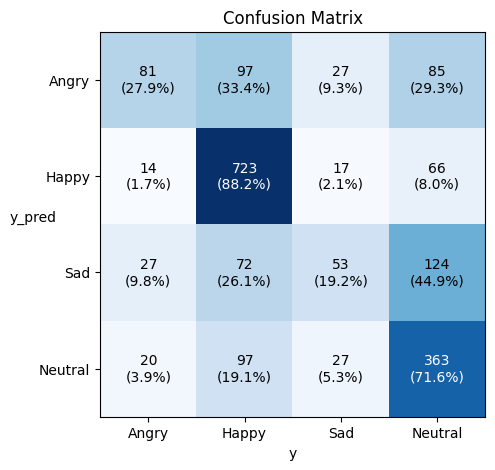

In [19]:
evaluate(
    lgbm,
    test_data[0].reshape(-1, 36*36),
    test_data[1],
    is_torch=False
)

## CatBoost

In [20]:
from catboost import CatBoostClassifier

In [21]:
catb = CatBoostClassifier()

In [22]:
catb.fit(
    train_data[0].reshape(-1, 36*36), 
    train_data[1]
)

Learning rate set to 0.087732
0:	learn: 1.3508595	total: 190ms	remaining: 3m 9s
1:	learn: 1.3194968	total: 276ms	remaining: 2m 17s
2:	learn: 1.2959105	total: 362ms	remaining: 2m
3:	learn: 1.2758653	total: 451ms	remaining: 1m 52s
4:	learn: 1.2574562	total: 538ms	remaining: 1m 47s
5:	learn: 1.2414099	total: 624ms	remaining: 1m 43s
6:	learn: 1.2270494	total: 711ms	remaining: 1m 40s
7:	learn: 1.2128388	total: 799ms	remaining: 1m 39s
8:	learn: 1.1992546	total: 885ms	remaining: 1m 37s
9:	learn: 1.1877805	total: 971ms	remaining: 1m 36s
10:	learn: 1.1772442	total: 1.06s	remaining: 1m 35s
11:	learn: 1.1684862	total: 1.15s	remaining: 1m 34s
12:	learn: 1.1586135	total: 1.23s	remaining: 1m 33s
13:	learn: 1.1498655	total: 1.32s	remaining: 1m 32s
14:	learn: 1.1419359	total: 1.41s	remaining: 1m 32s
15:	learn: 1.1343564	total: 1.49s	remaining: 1m 31s
16:	learn: 1.1277250	total: 1.58s	remaining: 1m 31s
17:	learn: 1.1200018	total: 1.67s	remaining: 1m 31s
18:	learn: 1.1136000	total: 1.75s	remaining: 1m 3

157:	learn: 0.7920222	total: 13.8s	remaining: 1m 13s
158:	learn: 0.7910603	total: 13.9s	remaining: 1m 13s
159:	learn: 0.7896041	total: 14s	remaining: 1m 13s
160:	learn: 0.7881479	total: 14.1s	remaining: 1m 13s
161:	learn: 0.7869339	total: 14.2s	remaining: 1m 13s
162:	learn: 0.7861079	total: 14.2s	remaining: 1m 13s
163:	learn: 0.7850492	total: 14.3s	remaining: 1m 13s
164:	learn: 0.7841101	total: 14.4s	remaining: 1m 12s
165:	learn: 0.7822473	total: 14.5s	remaining: 1m 12s
166:	learn: 0.7804397	total: 14.6s	remaining: 1m 12s
167:	learn: 0.7787179	total: 14.7s	remaining: 1m 12s
168:	learn: 0.7776088	total: 14.8s	remaining: 1m 12s
169:	learn: 0.7759526	total: 14.8s	remaining: 1m 12s
170:	learn: 0.7754113	total: 14.9s	remaining: 1m 12s
171:	learn: 0.7742598	total: 15s	remaining: 1m 12s
172:	learn: 0.7725912	total: 15.1s	remaining: 1m 12s
173:	learn: 0.7716744	total: 15.2s	remaining: 1m 12s
174:	learn: 0.7704459	total: 15.3s	remaining: 1m 12s
175:	learn: 0.7693137	total: 15.4s	remaining: 1m 1

316:	learn: 0.6237315	total: 27.6s	remaining: 59.4s
317:	learn: 0.6228524	total: 27.7s	remaining: 59.3s
318:	learn: 0.6220855	total: 27.8s	remaining: 59.2s
319:	learn: 0.6211885	total: 27.8s	remaining: 59.2s
320:	learn: 0.6205892	total: 27.9s	remaining: 59.1s
321:	learn: 0.6198645	total: 28s	remaining: 59s
322:	learn: 0.6190911	total: 28.1s	remaining: 58.9s
323:	learn: 0.6180854	total: 28.2s	remaining: 58.8s
324:	learn: 0.6175321	total: 28.3s	remaining: 58.7s
325:	learn: 0.6167969	total: 28.4s	remaining: 58.6s
326:	learn: 0.6163728	total: 28.4s	remaining: 58.5s
327:	learn: 0.6156888	total: 28.5s	remaining: 58.5s
328:	learn: 0.6146567	total: 28.6s	remaining: 58.4s
329:	learn: 0.6141849	total: 28.7s	remaining: 58.3s
330:	learn: 0.6131993	total: 28.8s	remaining: 58.2s
331:	learn: 0.6121636	total: 28.9s	remaining: 58.1s
332:	learn: 0.6116599	total: 29s	remaining: 58s
333:	learn: 0.6109363	total: 29s	remaining: 57.9s
334:	learn: 0.6099718	total: 29.1s	remaining: 57.8s
335:	learn: 0.6090697	

475:	learn: 0.5136433	total: 41.3s	remaining: 45.5s
476:	learn: 0.5130711	total: 41.4s	remaining: 45.4s
477:	learn: 0.5124792	total: 41.5s	remaining: 45.3s
478:	learn: 0.5116450	total: 41.6s	remaining: 45.3s
479:	learn: 0.5112948	total: 41.7s	remaining: 45.2s
480:	learn: 0.5105274	total: 41.8s	remaining: 45.1s
481:	learn: 0.5098721	total: 41.9s	remaining: 45s
482:	learn: 0.5094006	total: 41.9s	remaining: 44.9s
483:	learn: 0.5090099	total: 42s	remaining: 44.8s
484:	learn: 0.5084086	total: 42.1s	remaining: 44.7s
485:	learn: 0.5080294	total: 42.2s	remaining: 44.6s
486:	learn: 0.5076261	total: 42.3s	remaining: 44.6s
487:	learn: 0.5068570	total: 42.4s	remaining: 44.5s
488:	learn: 0.5064089	total: 42.5s	remaining: 44.4s
489:	learn: 0.5058004	total: 42.6s	remaining: 44.3s
490:	learn: 0.5053710	total: 42.6s	remaining: 44.2s
491:	learn: 0.5050028	total: 42.7s	remaining: 44.1s
492:	learn: 0.5042050	total: 42.8s	remaining: 44s
493:	learn: 0.5037633	total: 42.9s	remaining: 43.9s
494:	learn: 0.5032

634:	learn: 0.4278317	total: 55.1s	remaining: 31.7s
635:	learn: 0.4274678	total: 55.2s	remaining: 31.6s
636:	learn: 0.4269820	total: 55.3s	remaining: 31.5s
637:	learn: 0.4261930	total: 55.4s	remaining: 31.4s
638:	learn: 0.4255974	total: 55.4s	remaining: 31.3s
639:	learn: 0.4252300	total: 55.5s	remaining: 31.2s
640:	learn: 0.4247790	total: 55.6s	remaining: 31.1s
641:	learn: 0.4241558	total: 55.7s	remaining: 31.1s
642:	learn: 0.4235403	total: 55.8s	remaining: 31s
643:	learn: 0.4230521	total: 55.9s	remaining: 30.9s
644:	learn: 0.4223091	total: 56s	remaining: 30.8s
645:	learn: 0.4219442	total: 56s	remaining: 30.7s
646:	learn: 0.4215147	total: 56.1s	remaining: 30.6s
647:	learn: 0.4210813	total: 56.2s	remaining: 30.5s
648:	learn: 0.4205965	total: 56.3s	remaining: 30.5s
649:	learn: 0.4204305	total: 56.4s	remaining: 30.4s
650:	learn: 0.4201129	total: 56.5s	remaining: 30.3s
651:	learn: 0.4198135	total: 56.6s	remaining: 30.2s
652:	learn: 0.4192944	total: 56.7s	remaining: 30.1s
653:	learn: 0.4189

796:	learn: 0.3595887	total: 1m 9s	remaining: 17.6s
797:	learn: 0.3592140	total: 1m 9s	remaining: 17.5s
798:	learn: 0.3589264	total: 1m 9s	remaining: 17.4s
799:	learn: 0.3586359	total: 1m 9s	remaining: 17.3s
800:	learn: 0.3583101	total: 1m 9s	remaining: 17.3s
801:	learn: 0.3577455	total: 1m 9s	remaining: 17.2s
802:	learn: 0.3573261	total: 1m 9s	remaining: 17.1s
803:	learn: 0.3571045	total: 1m 9s	remaining: 17s
804:	learn: 0.3567717	total: 1m 9s	remaining: 16.9s
805:	learn: 0.3565225	total: 1m 9s	remaining: 16.8s
806:	learn: 0.3560032	total: 1m 9s	remaining: 16.7s
807:	learn: 0.3556009	total: 1m 10s	remaining: 16.6s
808:	learn: 0.3552495	total: 1m 10s	remaining: 16.6s
809:	learn: 0.3547854	total: 1m 10s	remaining: 16.5s
810:	learn: 0.3544618	total: 1m 10s	remaining: 16.4s
811:	learn: 0.3539554	total: 1m 10s	remaining: 16.3s
812:	learn: 0.3536565	total: 1m 10s	remaining: 16.2s
813:	learn: 0.3532219	total: 1m 10s	remaining: 16.1s
814:	learn: 0.3531196	total: 1m 10s	remaining: 16s
815:	lea

952:	learn: 0.3086785	total: 1m 22s	remaining: 4.07s
953:	learn: 0.3084262	total: 1m 22s	remaining: 3.99s
954:	learn: 0.3082106	total: 1m 22s	remaining: 3.9s
955:	learn: 0.3078991	total: 1m 22s	remaining: 3.81s
956:	learn: 0.3075026	total: 1m 22s	remaining: 3.73s
957:	learn: 0.3073731	total: 1m 23s	remaining: 3.64s
958:	learn: 0.3069273	total: 1m 23s	remaining: 3.55s
959:	learn: 0.3065987	total: 1m 23s	remaining: 3.47s
960:	learn: 0.3062719	total: 1m 23s	remaining: 3.38s
961:	learn: 0.3060174	total: 1m 23s	remaining: 3.29s
962:	learn: 0.3057017	total: 1m 23s	remaining: 3.21s
963:	learn: 0.3054315	total: 1m 23s	remaining: 3.12s
964:	learn: 0.3052590	total: 1m 23s	remaining: 3.03s
965:	learn: 0.3050681	total: 1m 23s	remaining: 2.95s
966:	learn: 0.3046265	total: 1m 23s	remaining: 2.86s
967:	learn: 0.3043076	total: 1m 23s	remaining: 2.77s
968:	learn: 0.3038697	total: 1m 23s	remaining: 2.69s
969:	learn: 0.3036245	total: 1m 24s	remaining: 2.6s
970:	learn: 0.3034624	total: 1m 24s	remaining: 2


Classification Report
              precision    recall  f1-score   support

           0       0.30      0.54      0.38       159
           1       0.88      0.74      0.80       979
           2       0.19      0.51      0.28       102
           3       0.74      0.57      0.64       653

    accuracy                           0.65      1893
   macro avg       0.52      0.59      0.53      1893
weighted avg       0.74      0.65      0.68      1893



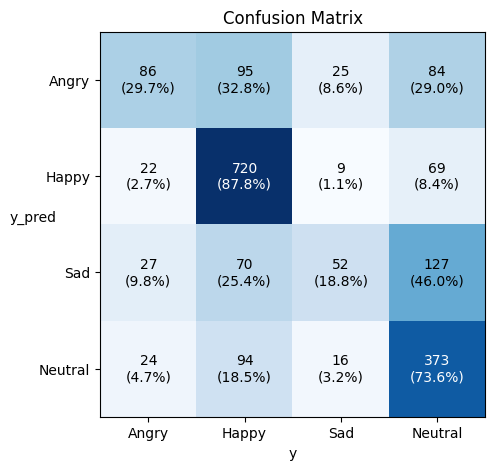

In [23]:
evaluate(
    catb,
    test_data[0].reshape(-1, 36*36),
    test_data[1],
    is_torch=False
)

## CNN

In [85]:
model = FERClassifier()
model

FERClassifier(
  (cnn): CNN(
    (embedding): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (cnn): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 

In [86]:
optimizer = optim.Adam(model.parameters())
crit = nn.NLLLoss(weight=torch.Tensor([1., 1., 1., 1.]), reduction='none')

In [87]:
epochs = 10
early_stop=5
batch_size=256

In [88]:
def transform_tensor(data):
    return torch.Tensor(data[0].reshape(-1, 1, 36, 36)), torch.tensor(data[1])

In [89]:
torch_train = transform_tensor(train_data)
torch_test = transform_tensor(test_data)

In [90]:
trainer = Trainer(model, crit, optimizer)

Epoch 1: train_loss=1.12372, valid_loss=0.83541, lowest_loss=0.83541
Epoch 2: train_loss=0.74132, valid_loss=0.74654, lowest_loss=0.74654
Epoch 3: train_loss=0.62647, valid_loss=0.7657, lowest_loss=0.74654
Epoch 4: train_loss=0.56245, valid_loss=0.72887, lowest_loss=0.72887
Epoch 5: train_loss=0.4561, valid_loss=0.7772, lowest_loss=0.72887
Epoch 6: train_loss=0.41844, valid_loss=0.90181, lowest_loss=0.72887
Epoch 7: train_loss=0.34776, valid_loss=0.80157, lowest_loss=0.72887
Epoch 8: train_loss=0.28295, valid_loss=0.84748, lowest_loss=0.72887
Early Stop at Epoch 9. Lowest Loss 0.72887 at 4 epoch
The best validstion loss from epoch=4, loss=0.72887


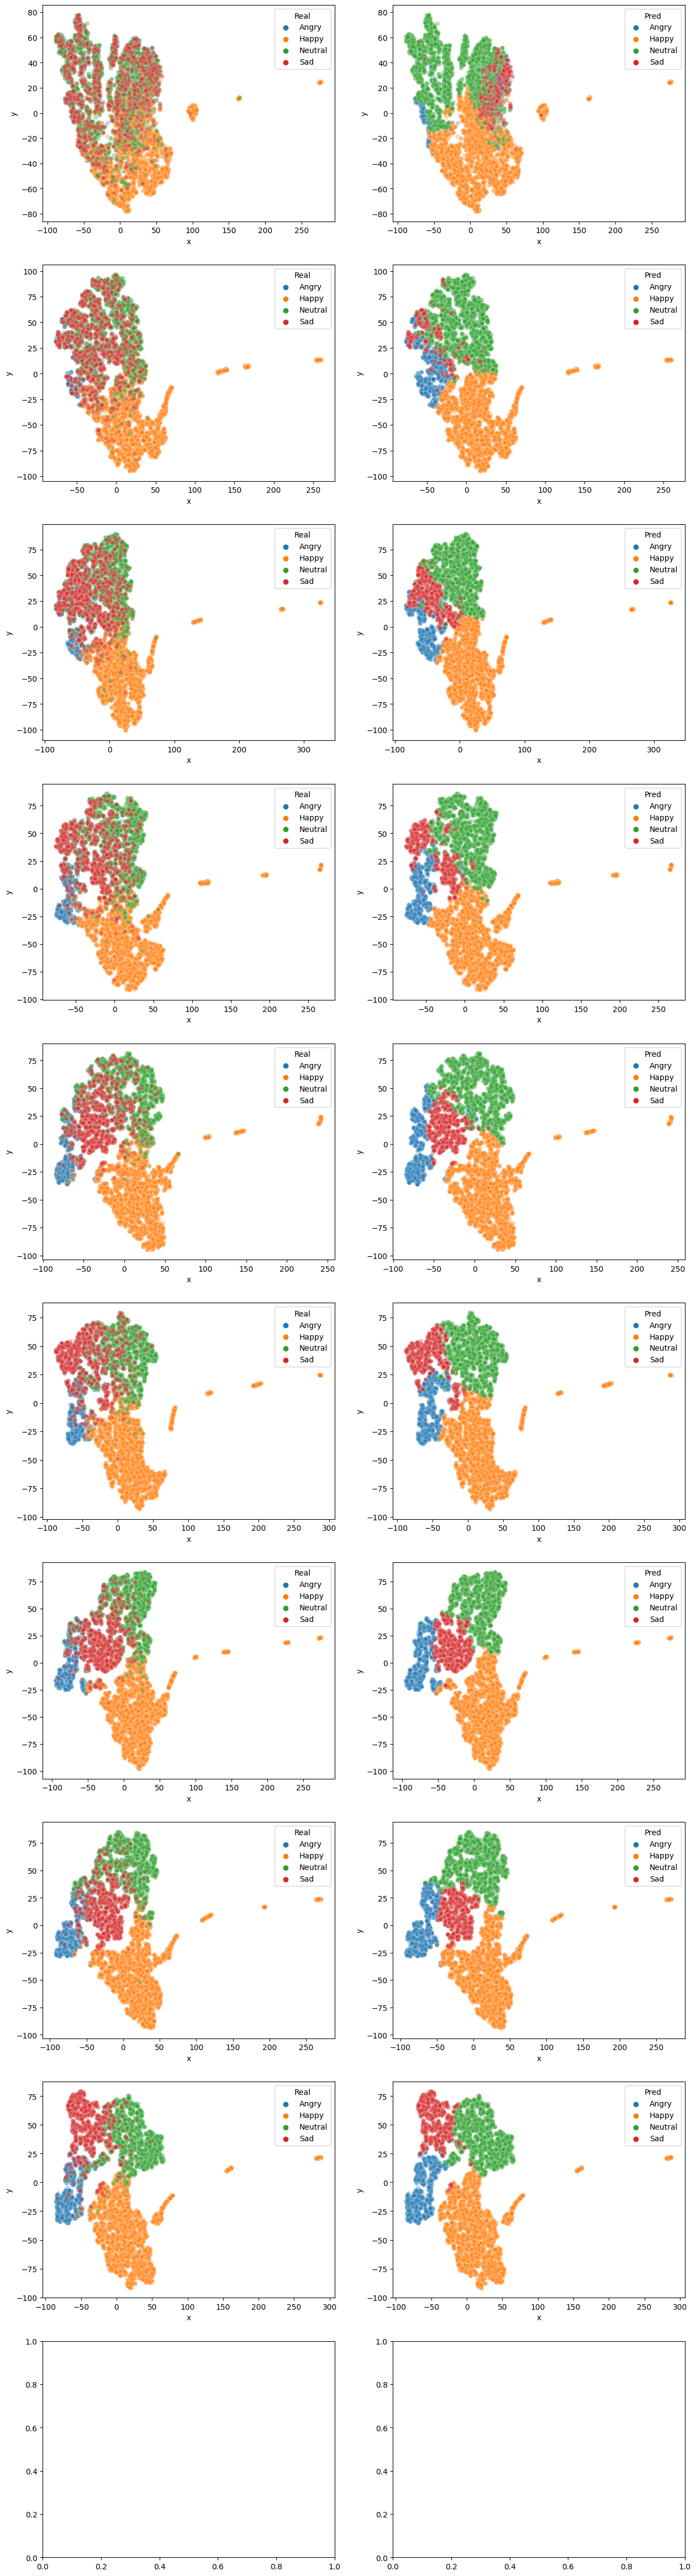

In [91]:
trainer.train(torch_train, torch_test, epochs=epochs, batch_size=batch_size, early_stop=early_stop, figsize=(15, 60))


Classification Report
              precision    recall  f1-score   support

           0       0.57      0.56      0.56       295
           1       0.89      0.90      0.90       817
           2       0.22      0.47      0.30       132
           3       0.79      0.62      0.69       649

    accuracy                           0.72      1893
   macro avg       0.62      0.64      0.61      1893
weighted avg       0.76      0.72      0.73      1893



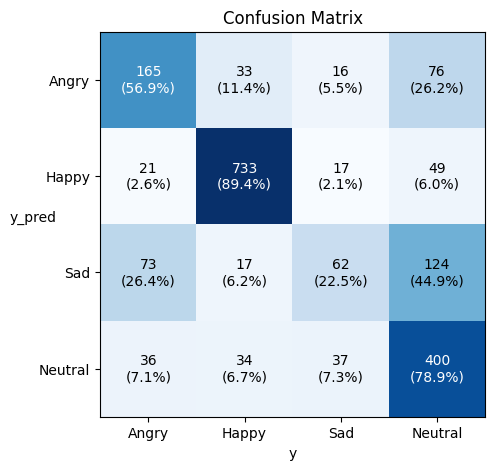

In [92]:
evaluate(trainer.model, torch_test[0], torch_test[1])

## Compare Result

In [93]:
def plot_cm(ax, model, X, y, is_torch=False, label_map=CLASS_LABEL):
    if is_torch:
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        model = model.to(device)
        X = X.to(device)
        y = y.to(device)

        with torch.no_grad():
            y_hat, z = model(X)
            if isinstance(y_hat, tuple):
                y_hat = y_hat[0]

        y_pred = np.array(y_hat.cpu().argmax(dim=-1))
        y = np.array(y.cpu())
        
    else:
        y_pred = model.predict(X)
    
    cm = confusion_matrix(y, y_pred, normalize='true')
    cm2 = confusion_matrix(y, y_pred)
    
    label_index = list(label_map.keys())
    label_name = list(label_map.values())
    
    ax.imshow(cm, cmap='Blues')
    for i in label_index:
        for j in label_index:
            ax.text(
                i, j, '{}\n({}%)'.format(cm2[j][i], round(cm[j][i] * 100, 1)) ,
                horizontalalignment="center",
                verticalalignment="center",
                color='black' if cm[j][i] < 0.5 else 'white'
                
            )
    ax.set_xticks(label_index, label_name)
    ax.set_yticks(label_index, label_name)

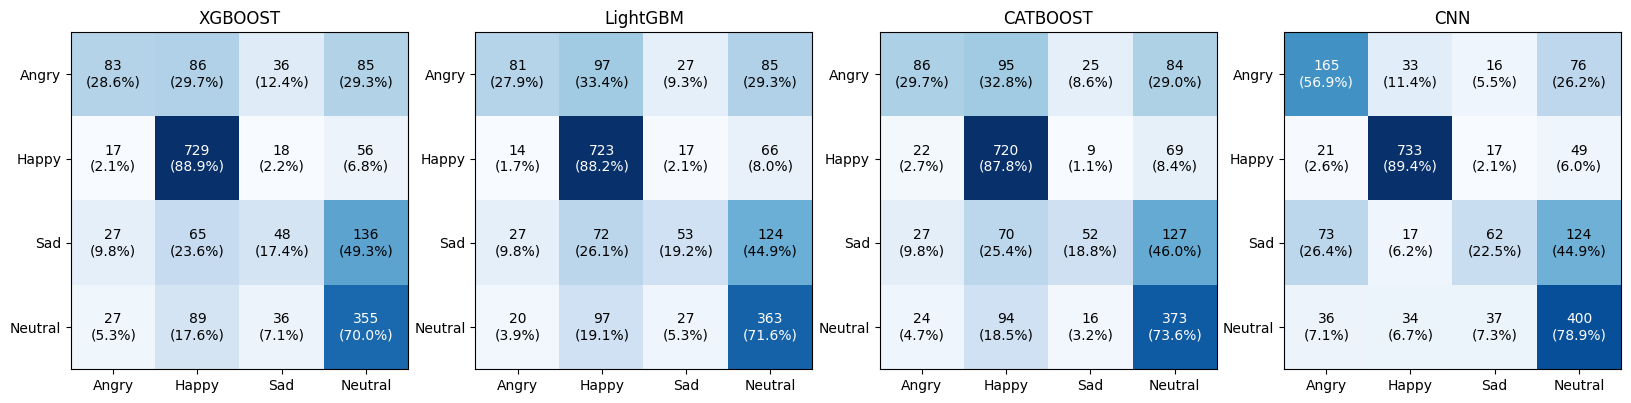

In [94]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
plot_cm(ax[0], xgb, test_data[0].reshape(-1, 36*36), test_data[1])
ax[0].set_title('XGBOOST')
plot_cm(ax[1], lgbm, test_data[0].reshape(-1, 36*36), test_data[1])
ax[1].set_title('LightGBM')
plot_cm(ax[2], catb, test_data[0].reshape(-1, 36*36), test_data[1])
ax[2].set_title('CATBOOST')
plot_cm(ax[3], model, torch_test[0], torch_test[1], is_torch=True)
ax[3].set_title('CNN')

plt.show()

#### Weighted avg

|구 분|정확도|정밀도|재현율|F1|
|---:|---:|---:|---:|---:|
|**XGBOOST**|0.64|0.72|0.64|0.67|
|**LightGBM**|0.64|0.74|0.64|0.68|
|**CATBOOST**|0.65|0.74|0.65|0.68|
|**CNN**|<span style="color:red">0.72|<span style="color:red">0.76|<span style="color:red">0.72|<span style="color:red">0.73|

#### Macro avg

|구 분|정확도|정밀도|재현율|F1|
|---:|---:|---:|---:|---:|
|**XGBOOST**|0.64|0.51|0.55|0.51|
|**LightGBM**|0.64|0.52|0.57|0.52|
|**CATBOOST**|0.65|0.52|0.59|0.53|
|**CNN**|<span style="color:red">0.71|<span style="color:red">0.62|<span style="color:red">0.64|<span style="color:red">0.61|

## Boosting Model Feature Importance

In [95]:
from sklearn.preprocessing import MinMaxScaler

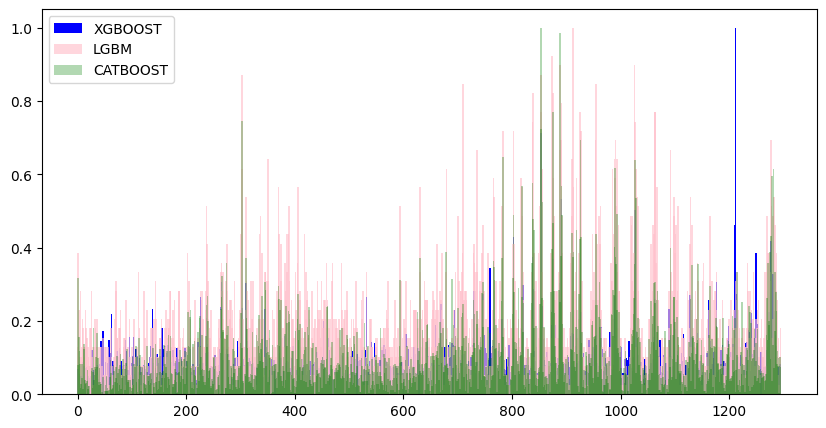

In [96]:
def scaling(a):
    scaler = MinMaxScaler()
    return scaler.fit_transform(a.reshape(-1, 1)).reshape(-1)

models = [('XGBOOST', xgb, 'blue'), ('LGBM', lgbm, 'pink'), ('CATBOOST', catb, 'green')]
plt.figure(figsize=(10, 5))
for i, (n, m, c) in enumerate(models):
    plt.bar(
        range(len(m.feature_importances_)),
        scaling(m.feature_importances_), 
        alpha=(1 - 0.35 * i), color=c, width=3,
        label=n
    )
    plt.legend()

## Miss Classification

In [97]:
with torch.no_grad():
    y_pred, latent_vector = trainer.model(torch_test[0].to(trainer.device))
    loss = trainer.crit(y_pred, torch_test[1].to(trainer.device))

In [98]:
y_pred = y_pred.cpu().numpy()
loss = loss.cpu().numpy()

In [99]:
wrong_idx = np.where(test_data[1] != y_pred.argmax(axis=-1))[0]

loss = loss[wrong_idx]
wrong_X = test_data[0][wrong_idx]
wrong_y = test_data[1][wrong_idx]
wrong_pred = y_pred.argmax(axis=-1)[wrong_idx]

In [100]:
top_miss_idx = loss.argsort()[-50:]

In [101]:
top_miss_img = wrong_X[top_miss_idx].reshape(-1, 36, 36)
top_miss_label = wrong_y[top_miss_idx]
top_miss_pred = wrong_pred[top_miss_idx]

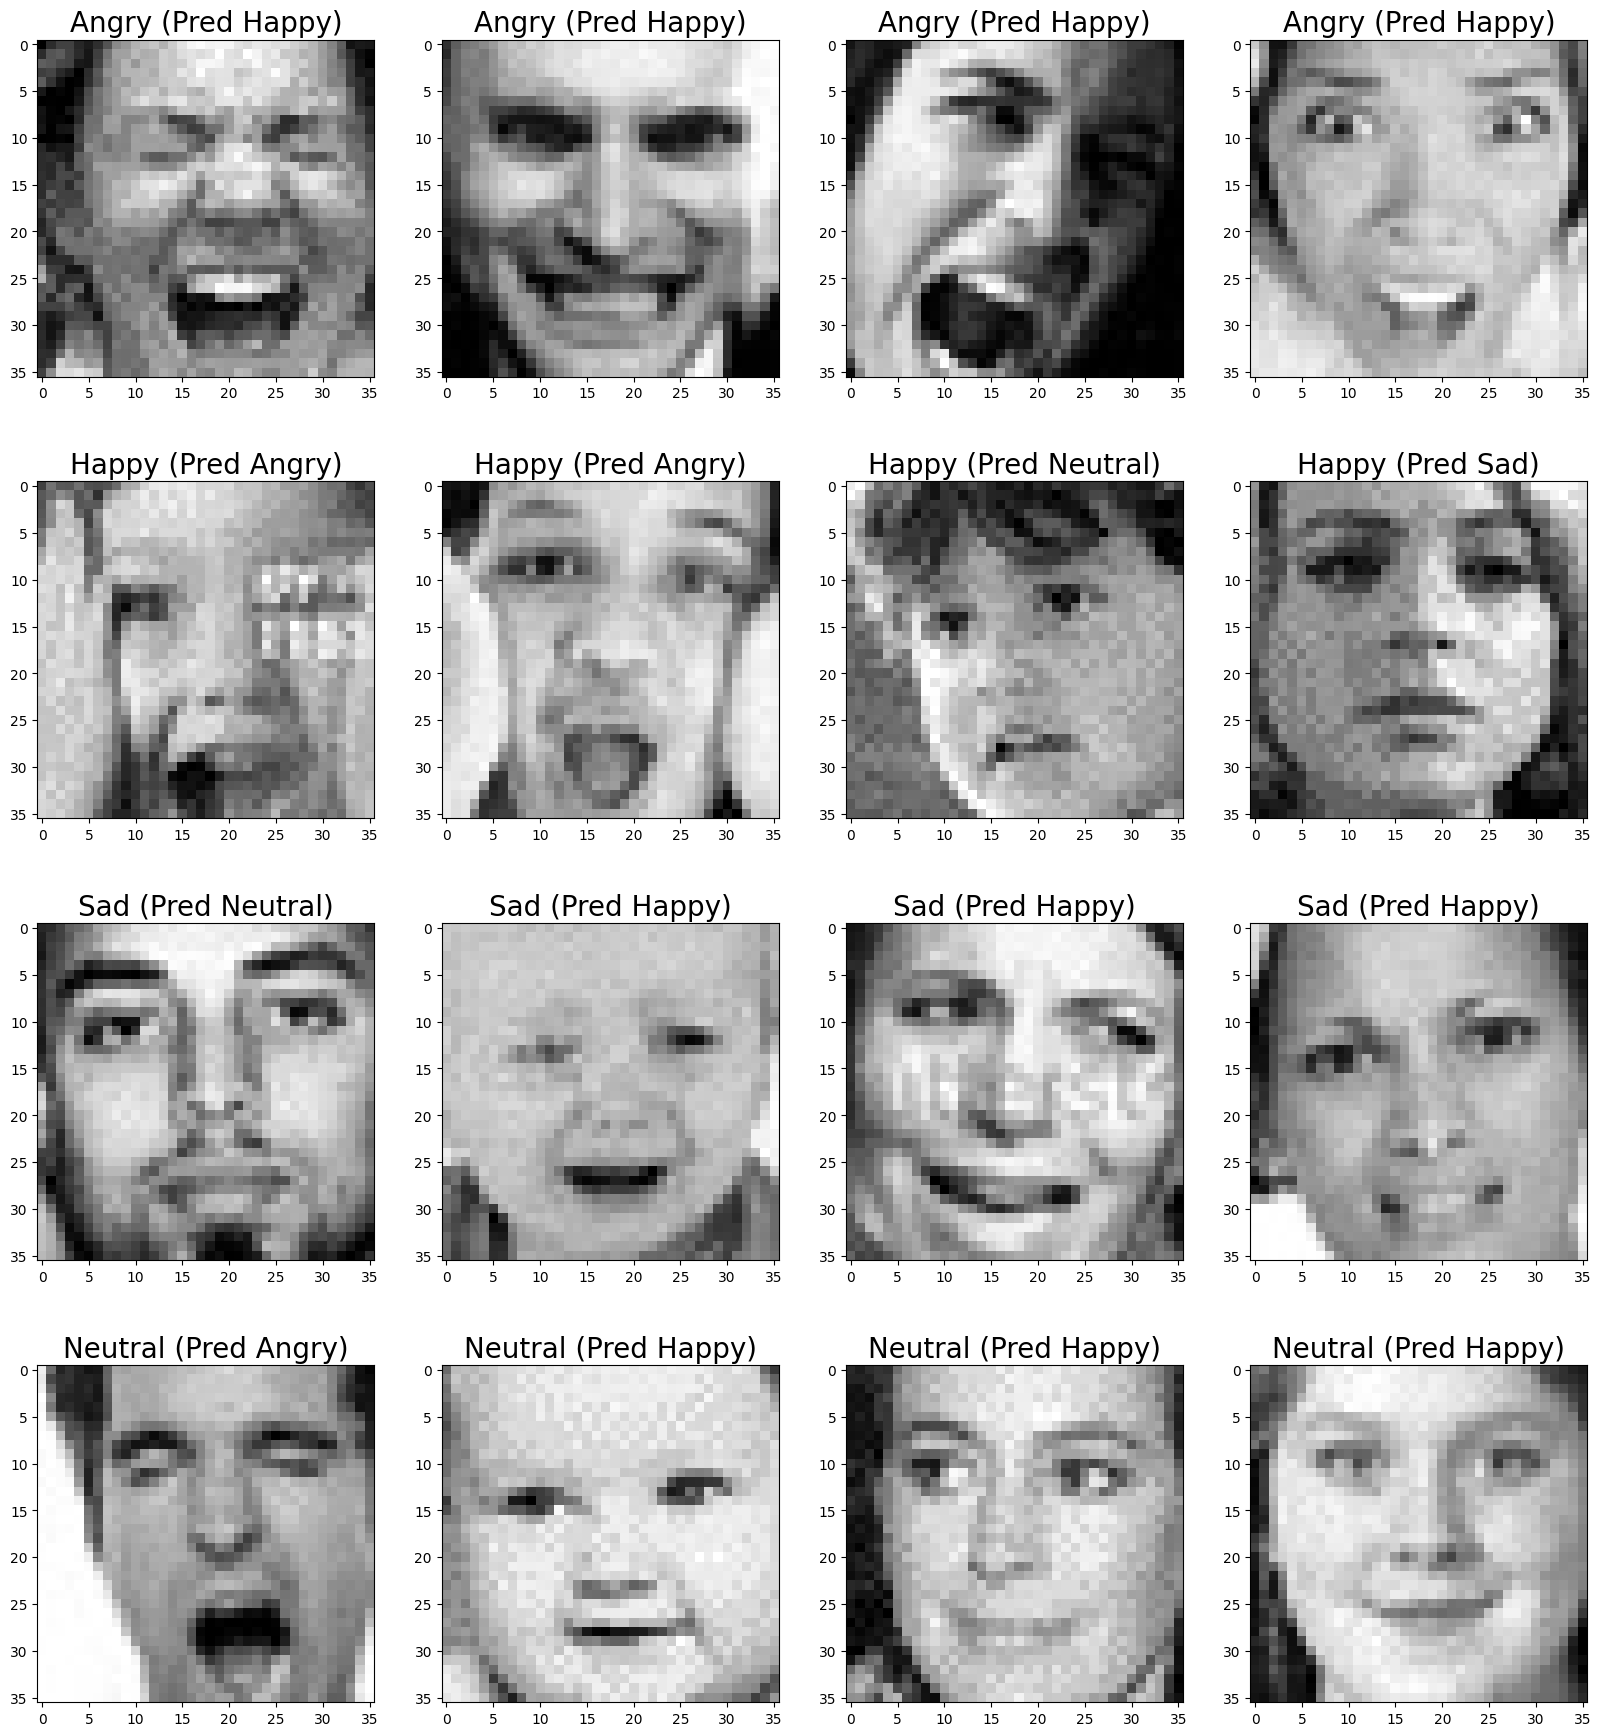

In [102]:
label = [0, 1, 2, 3]
classes = ['Angry', 'Happy', 'Sad', 'Neutral']
fig, ax = plt.subplots(4, 4, figsize=(20, 22))
for l in label:
    idx = np.where(top_miss_label == l)[0]
    for i, target in enumerate(idx[-4:]):
        ax[l, i].imshow(top_miss_img[target], cmap='gray')
        ax[l, i].set_title(f"{classes[l]} (Pred {classes[top_miss_pred[target]]})", fontsize=20)
plt.show()

# OverSamling

## SMOTE -  Same class ratio

In [12]:
smote_params = {}

X_, y_ = preprocessing(
    X, y,
    test_ratio=.2,
    random_state=111,
    o_sampling='smote',
    u_sampling=None,
    **smote_params
)
train_data = (X_[0], y_[0])
test_data = (X_[1], y_[1])

Before: X((7571, 1296)), y((7571,))
Before Class: Counter({1: 3280, 3: 2028, 0: 1160, 2: 1103})
After Over Sampling: X((13120, 1296)), y((13120,))
After Over Sampling Class: Counter({1: 3280, 2: 3280, 3: 3280, 0: 3280})


In [13]:
print('X_train Shape:', train_data[0].shape)
print('y_train Shape:', train_data[1].shape)
print('Class Distribution:', dict(sorted(Counter(train_data[1]).items(), key=lambda x:x[0])))
print()
print('X_test Shape:', test_data[0].shape)
print('y_test Shape:', test_data[1].shape)
print('Class Distribution:', dict(sorted(Counter(test_data[1]).items(), key=lambda x:x[0])))

X_train Shape: (13120, 36, 36)
y_train Shape: (13120,)
Class Distribution: {0: 3280, 1: 3280, 2: 3280, 3: 3280}

X_test Shape: (1893, 36, 36)
y_test Shape: (1893,)
Class Distribution: {0: 290, 1: 820, 2: 276, 3: 507}


## Generated Image

In [14]:
before = pd.DataFrame((X / 255))
before_test = pd.DataFrame(test_data[0].reshape(-1, 36*36))
before['flag'] = 'x'
before['class'] = y
before_test['flag'] = 'test'
before_test['class'] = test_data[1]

In [15]:
after = pd.DataFrame(train_data[0].reshape(-1, 36*36))
after['flag'] = 'sampling'
after['class'] = train_data[1]

In [16]:
concated = pd.concat([before, before_test, after])

In [17]:
over_sampled_df = concated.loc[concated.drop(['flag', 'class'], axis=1).drop_duplicates(keep=False).index]
over_sampled_df = over_sampled_df[over_sampled_df.flag == 'sampling']

In [18]:
over_sampled_img = over_sampled_df.drop(['flag', 'class'], axis=1).values.reshape(-1, 36, 36)

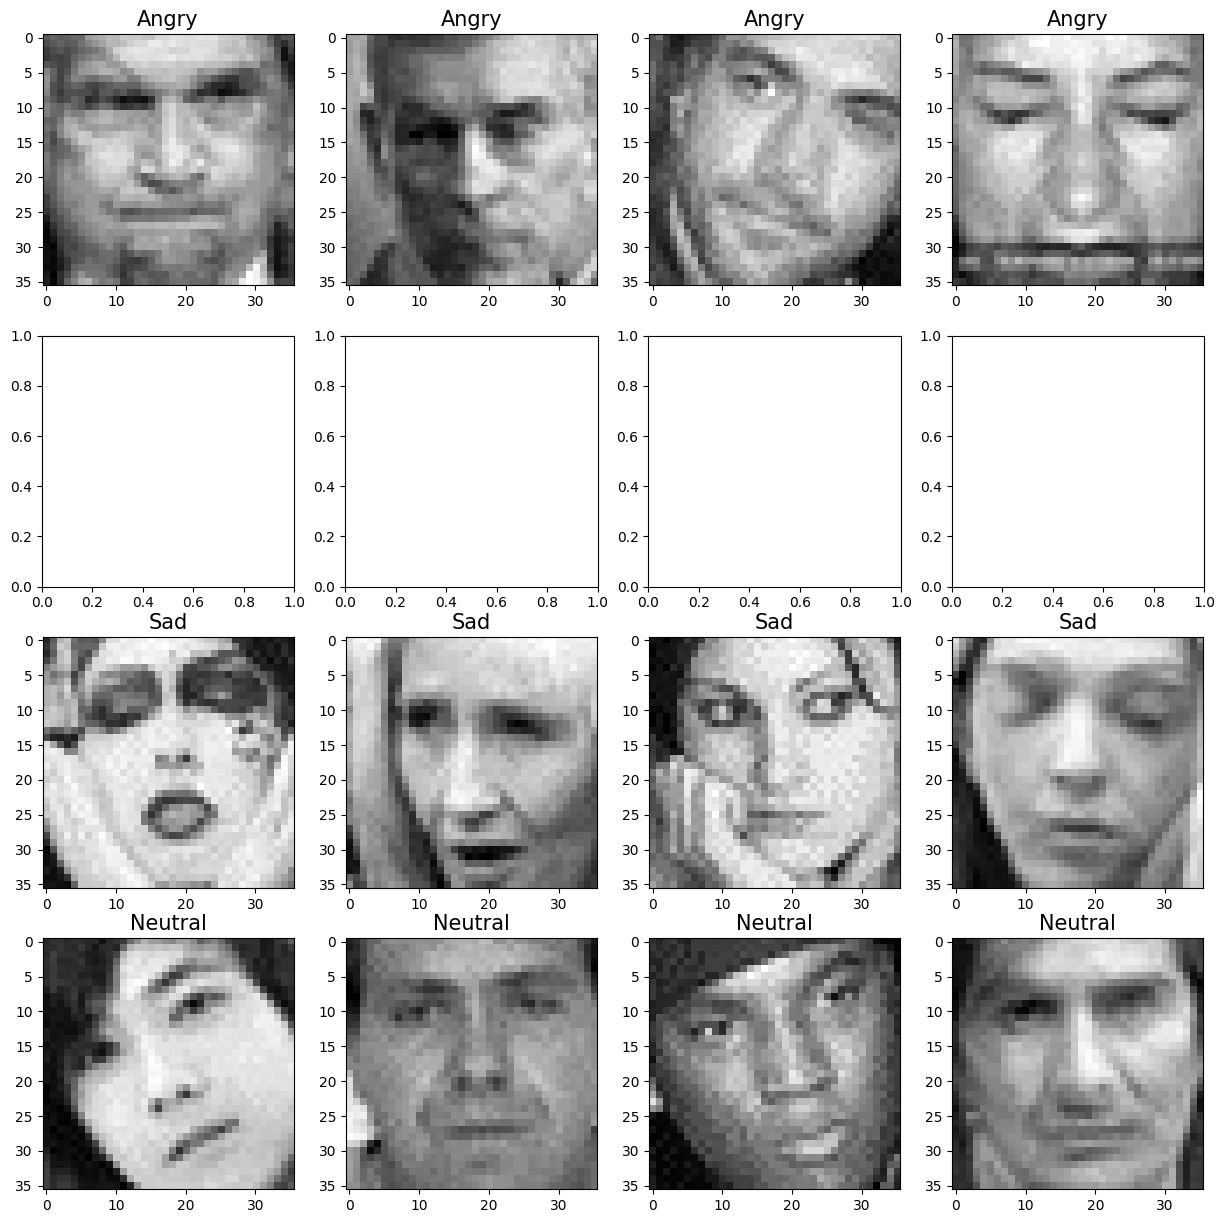

In [19]:
nrows = len(CLASS_LABEL)
ncols = 4

fig, ax = plt.subplots(nrows, ncols, figsize=(15, 15))

for k, v in CLASS_LABEL.items():
    if k == 1: continue
    for i, idx in enumerate(np.random.choice(over_sampled_df[over_sampled_df['class'] == k].index.values, ncols)):
        ax[k, i].imshow(over_sampled_df.loc[idx].values[:-2].reshape(36, 36).astype('float'), cmap='gray')
        ax[k, i].set_title(CLASS_LABEL[over_sampled_df.loc[idx].values[-1]], fontsize=15)
        
plt.show()

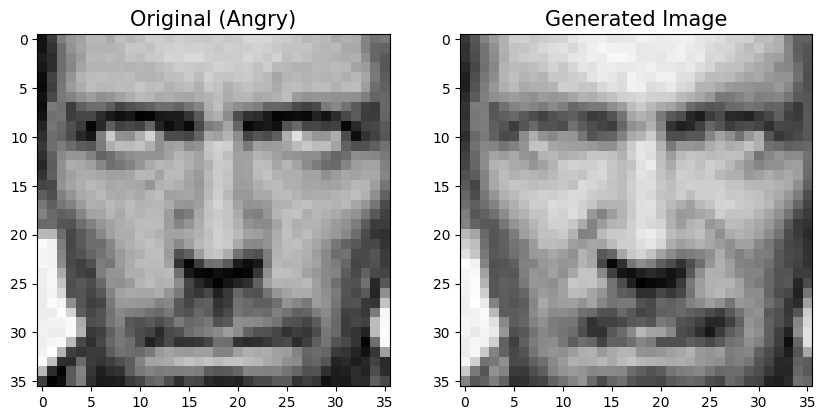

In [23]:
i = 3
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))
dist = np.linalg.norm(over_sampled_df.iloc[i].values[:-2].astype('float') - (X / 255), axis=1)
ax[0].imshow((X / 255)[dist.argmin()].reshape(36, 36), cmap='gray')
ax[1].imshow(over_sampled_df.iloc[i].values[:-2].astype('float').reshape(36, 36), cmap='gray')
ax[0].set_title('Original ({})'.format(CLASS_LABEL[over_sampled_df.iloc[i].values[-1]]), fontsize=15)
ax[1].set_title('Generated Image', fontsize=15)
plt.show()

### CNN

In [185]:
model = FERClassifier()

In [186]:
optimizer = optim.Adam(model.parameters())
crit = nn.NLLLoss(weight=torch.Tensor([1., 1., 1., 1.]), reduction='none')

In [187]:
torch_train = transform_tensor(train_data)
torch_test = transform_tensor(test_data)

In [188]:
trainer = Trainer(model, crit, optimizer)

In [189]:
trainer.train(torch_train, torch_test, epochs=epochs, batch_size=batch_size, early_stop=early_stop, figsize=None)

Epoch 1: train_loss=1.28781, valid_loss=1.02794, lowest_loss=1.02794
Epoch 2: train_loss=0.81072, valid_loss=0.92266, lowest_loss=0.92266
Epoch 3: train_loss=0.62354, valid_loss=1.16352, lowest_loss=0.92266
Epoch 4: train_loss=0.46837, valid_loss=1.09972, lowest_loss=0.92266
Epoch 5: train_loss=0.35515, valid_loss=1.15339, lowest_loss=0.92266
Epoch 6: train_loss=0.28309, valid_loss=1.34677, lowest_loss=0.92266
Early Stop at Epoch 7. Lowest Loss 0.92266 at 2 epoch
The best validstion loss from epoch=2, loss=0.92266



Classification Report
              precision    recall  f1-score   support

           0       0.55      0.44      0.49       364
           1       0.78      0.94      0.85       685
           2       0.51      0.38      0.43       378
           3       0.59      0.64      0.61       466

    accuracy                           0.66      1893
   macro avg       0.61      0.60      0.60      1893
weighted avg       0.64      0.66      0.64      1893



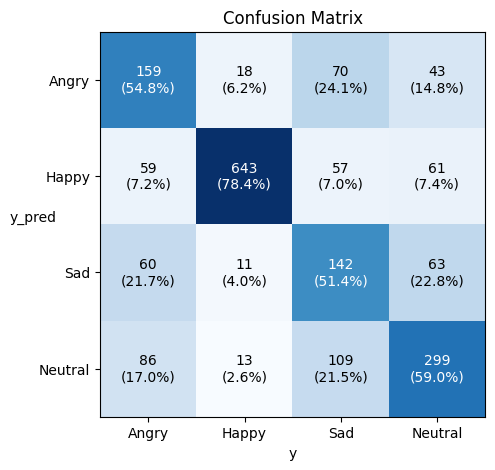

In [190]:
evaluate(trainer.model, torch_test[0], torch_test[1])

#### Weighted avg  

|구 분|정확도|정밀도|재현율|F1|
|---:|---:|---:|---:|---:|
|**No Sampling**|<span style="color:red">0.72|<span style="color:red">0.76|<span style="color:red">0.72|<span style="color:red">0.73|
|**SMOTE**|0.66|0.64|0.66|0.64|

#### Macro avg  

|구 분|정확도|정밀도|재현율|F1|
|---:|---:|---:|---:|---:|
|**No Sampling**|<span style="color:red">0.72|<span style="color:red">0.64|<span style="color:red">0.66|<span style="color:red">0.63|
|**SMOTE**|0.66|0.61|0.60|0.60|

## ADASYN -  Same class ratio

In [24]:
smote_params = {}

X_, y_ = preprocessing(
    X, y,
    test_ratio=.2,
    random_state=111,
    o_sampling='adasyn',
    u_sampling=None,
    **smote_params
)
train_data = (X_[0], y_[0])
test_data = (X_[1], y_[1])

Before: X((7571, 1296)), y((7571,))
Before Class: Counter({1: 3280, 3: 2028, 0: 1160, 2: 1103})
After Over Sampling: X((12699, 1296)), y((12699,))
After Over Sampling Class: Counter({1: 3280, 3: 3279, 0: 3152, 2: 2988})


In [25]:
print('X_train Shape:', train_data[0].shape)
print('y_train Shape:', train_data[1].shape)
print('Class Distribution:', dict(sorted(Counter(train_data[1]).items(), key=lambda x:x[0])))
print()
print('X_test Shape:', test_data[0].shape)
print('y_test Shape:', test_data[1].shape)
print('Class Distribution:', dict(sorted(Counter(test_data[1]).items(), key=lambda x:x[0])))

X_train Shape: (12699, 36, 36)
y_train Shape: (12699,)
Class Distribution: {0: 3152, 1: 3280, 2: 2988, 3: 3279}

X_test Shape: (1893, 36, 36)
y_test Shape: (1893,)
Class Distribution: {0: 290, 1: 820, 2: 276, 3: 507}


## Generated Image

In [26]:
before = pd.DataFrame((X / 255))
before_test = pd.DataFrame(test_data[0].reshape(-1, 36*36))
before['flag'] = 'x'
before['class'] = y
before_test['flag'] = 'test'
before_test['class'] = test_data[1]

In [27]:
after = pd.DataFrame(train_data[0].reshape(-1, 36*36))
after['flag'] = 'sampling'
after['class'] = train_data[1]

In [28]:
concated = pd.concat([before, before_test, after])

In [29]:
over_sampled_df = concated.loc[concated.drop(['flag', 'class'], axis=1).drop_duplicates(keep=False).index]
over_sampled_df = over_sampled_df[over_sampled_df.flag == 'sampling']

In [30]:
over_sampled_img = over_sampled_df.drop(['flag', 'class'], axis=1).values.reshape(-1, 36, 36)

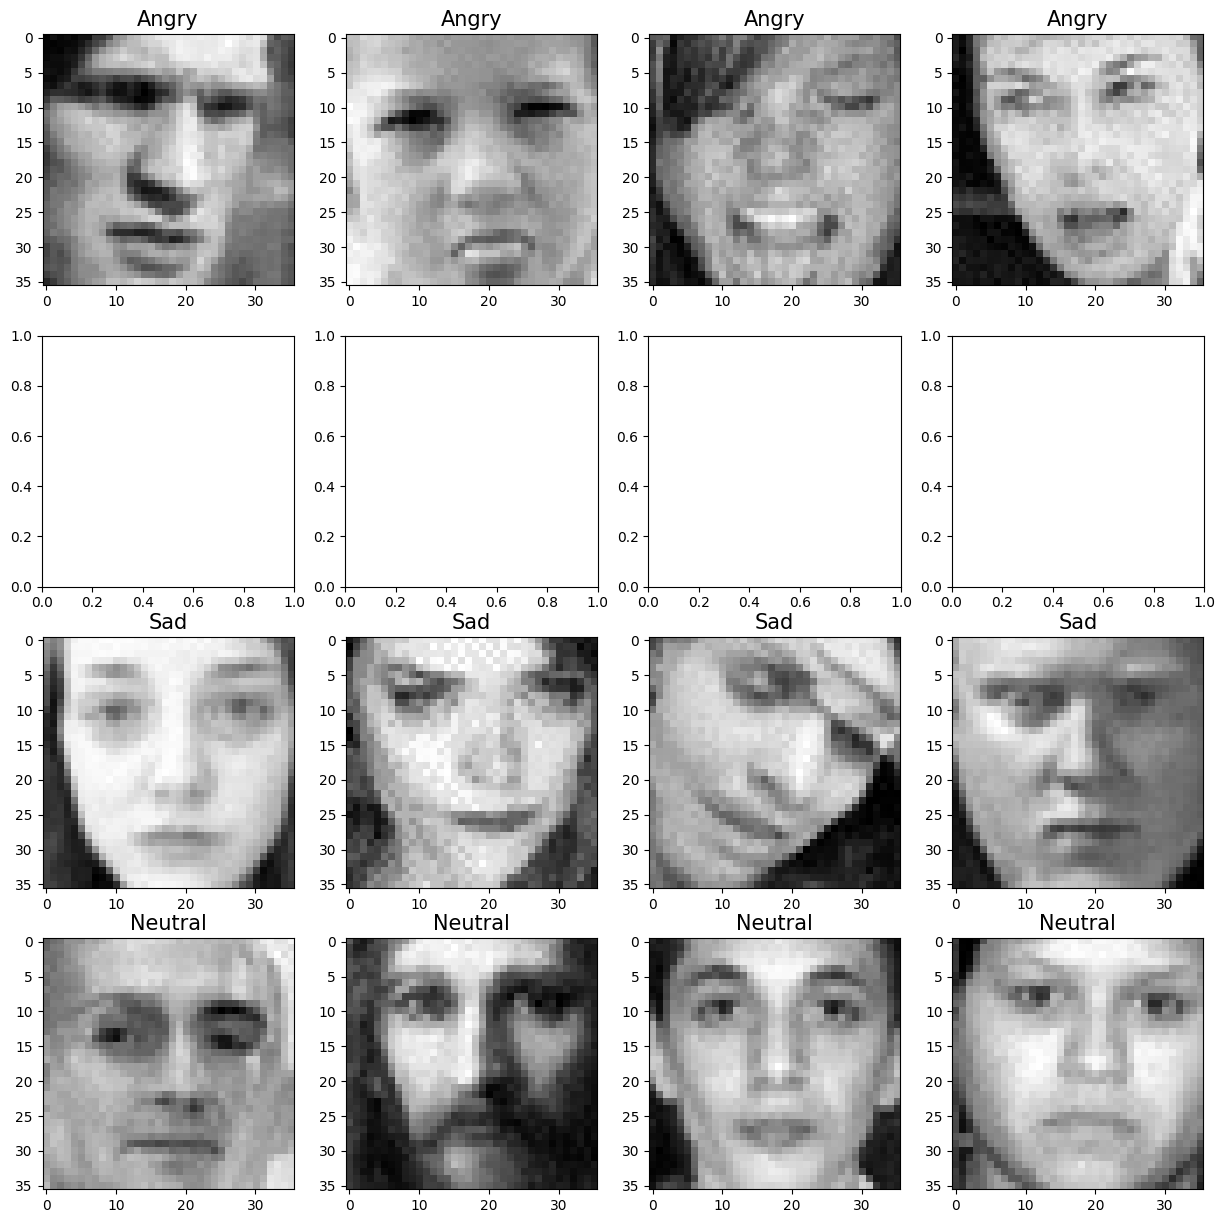

In [31]:
nrows = len(CLASS_LABEL)
ncols = 4

fig, ax = plt.subplots(nrows, ncols, figsize=(15, 15))

for k, v in CLASS_LABEL.items():
    if k == 1: continue
    for i, idx in enumerate(np.random.choice(over_sampled_df[over_sampled_df['class'] == k].index.values, ncols)):
        ax[k, i].imshow(over_sampled_df.loc[idx].values[:-2].reshape(36, 36).astype('float'), cmap='gray')
        ax[k, i].set_title(CLASS_LABEL[over_sampled_df.loc[idx].values[-1]], fontsize=15)
        
plt.show()

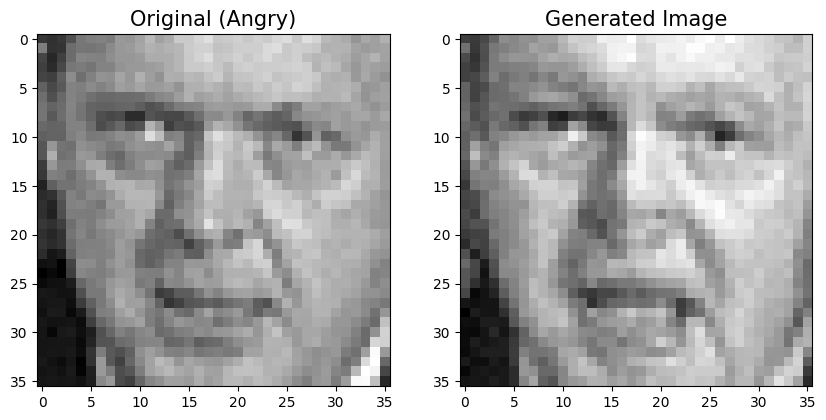

In [40]:
i = 7
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))
dist = np.linalg.norm(over_sampled_df.iloc[i].values[:-2].astype('float') - (X / 255), axis=1)
ax[0].imshow((X / 255)[dist.argmin()].reshape(36, 36), cmap='gray')
ax[1].imshow(over_sampled_df.iloc[i].values[:-2].astype('float').reshape(36, 36), cmap='gray')
ax[0].set_title('Original ({})'.format(CLASS_LABEL[over_sampled_df.iloc[i].values[-1]]), fontsize=15)
ax[1].set_title('Generated Image', fontsize=15)
plt.show()

In [ ]:
## Generated Image

before = pd.DataFrame((X / 255))
before_test = pd.DataFrame(test_data[0].reshape(-1, 36*36))
before['flag'] = 'x'
before['class'] = y
before_test['flag'] = 'test'
before_test['class'] = test_data[1]

after = pd.DataFrame(train_data[0].reshape(-1, 36*36))
after['flag'] = 'sampling'
after['class'] = train_data[1]

concated = pd.concat([before, before_test, after])

over_sampled_df = concated.loc[concated.drop(['flag', 'class'], axis=1).drop_duplicates(keep=False).index]
over_sampled_df = over_sampled_df[over_sampled_df.flag == 'sampling']

over_sampled_img = over_sampled_df.drop(['flag', 'class'], axis=1).values.reshape(-1, 36, 36)

nrows = len(CLASS_LABEL)
ncols = 4

fig, ax = plt.subplots(nrows, ncols, figsize=(15, 15))

for k, v in CLASS_LABEL.items():
    if k == 1: continue
    for i, idx in enumerate(np.random.choice(over_sampled_df[over_sampled_df['class'] == k].index.values, ncols)):
        ax[k, i].imshow(over_sampled_df.loc[idx].values[:-2].reshape(36, 36).astype('float'), cmap='gray')
        ax[k, i].set_title(CLASS_LABEL[over_sampled_df.loc[idx].values[-1]], fontsize=15)
        
plt.show()

i = 3
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))
dist = np.linalg.norm(over_sampled_df.iloc[i].values[:-2].astype('float') - (X / 255), axis=1)
ax[0].imshow((X / 255)[dist.argmin()].reshape(36, 36), cmap='gray')
ax[1].imshow(over_sampled_df.iloc[i].values[:-2].astype('float').reshape(36, 36), cmap='gray')
ax[0].set_title('Original ({})'.format(CLASS_LABEL[over_sampled_df.iloc[i].values[-1]]), fontsize=15)
ax[1].set_title('Generated Image', fontsize=15)
plt.show()

### CNN

In [193]:
model = FERClassifier()

In [194]:
optimizer = optim.Adam(model.parameters())
crit = nn.NLLLoss(weight=torch.Tensor([1., 1., 1., 1.]), reduction='none')

In [195]:
torch_train = transform_tensor(train_data)
torch_test = transform_tensor(test_data)

In [196]:
trainer = Trainer(model, crit, optimizer)

In [197]:
trainer.train(torch_train, torch_test, epochs=epochs, batch_size=batch_size, early_stop=early_stop,figsize=None)

Epoch 1: train_loss=1.30751, valid_loss=0.99636, lowest_loss=0.99636
Epoch 2: train_loss=0.91865, valid_loss=0.97092, lowest_loss=0.97092
Epoch 3: train_loss=0.75451, valid_loss=1.0807, lowest_loss=0.97092
Epoch 4: train_loss=0.64282, valid_loss=1.01646, lowest_loss=0.97092
Epoch 5: train_loss=0.5501, valid_loss=1.0294, lowest_loss=0.97092
Epoch 6: train_loss=0.42587, valid_loss=1.18711, lowest_loss=0.97092
Early Stop at Epoch 7. Lowest Loss 0.97092 at 2 epoch
The best validstion loss from epoch=2, loss=0.97092



Classification Report
              precision    recall  f1-score   support

           0       0.52      0.41      0.46       372
           1       0.71      0.95      0.81       611
           2       0.43      0.32      0.36       373
           3       0.64      0.60      0.62       537

    accuracy                           0.62      1893
   macro avg       0.57      0.57      0.56      1893
weighted avg       0.60      0.62      0.60      1893



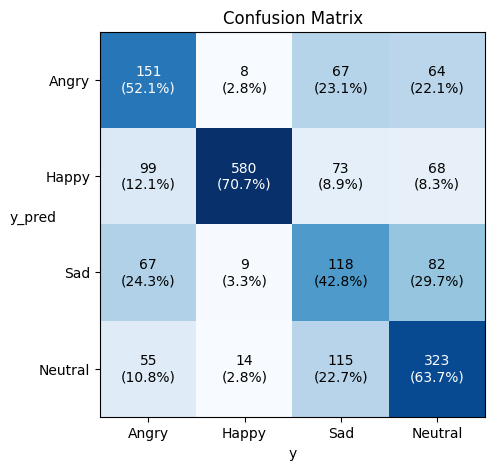

In [198]:
evaluate(trainer.model, torch_test[0], torch_test[1])

#### Weighted avg  

|구 분|정확도|정밀도|재현율|F1|
|---:|---:|---:|---:|---:|
|**No Sampling**|<span style="color:red">0.72|<span style="color:red">0.76|<span style="color:red">0.72|<span style="color:red">0.73|
|**SMOTE**|0.66|0.64|0.66|0.64|
|**ADASYN**|0.62|0.60|0.62|0.60|

#### Macro avg  

|구 분|정확도|정밀도|재현율|F1|
|---:|---:|---:|---:|---:|
|**No Sampling**|<span style="color:red">0.72|<span style="color:red">0.64|<span style="color:red">0.66|<span style="color:red">0.63|
|**SMOTE**|0.66|0.61|0.60|0.60|
|**ADASYN**|0.62|0.57|0.57|0.56|

## SMOTE - Different class ratio
- 최다 클래스(Happy)와 적용대상 클래스(Angry, Sad, Neutral) 차이의 절반만큼 추가로 증강

In [199]:
def oversample_criterion(v, max_v, over_ratio=.5):
    return v + int((max_v - v) * over_ratio)

In [200]:
train_ratio = .8
cls_cnt = sorted(Counter(y).items(), key=lambda x: x[1])
max_cls_cnt = cls_cnt[-1][-1]
cls_cnt

[(2, 1379), (0, 1450), (3, 2535), (1, 4100)]

In [201]:
smote_args = {
    "sampling_strategy": {
        k:oversample_criterion(int(v * train_ratio), int(max_cls_cnt * train_ratio))
        for k, v in cls_cnt
    }
}
smote_args

{'sampling_strategy': {2: 2191, 0: 2220, 3: 2654, 1: 3280}}

In [202]:
X_, y_ = preprocessing(
    X, y,
    test_ratio=.2,
    random_state=111,
    o_sampling='smote',
    u_sampling=None,
    **smote_args
)
train_data = (X_[0], y_[0])
test_data = (X_[1], y_[1])

Before: X((7571, 1296)), y((7571,))
Before Class: Counter({1: 3280, 3: 2028, 0: 1160, 2: 1103})
After Over Sampling: X((10345, 1296)), y((10345,))
After Over Sampling Class: Counter({1: 3280, 3: 2654, 0: 2220, 2: 2191})


### CNN

In [209]:
model = FERClassifier()

In [210]:
optimizer = optim.Adam(model.parameters())
crit = nn.NLLLoss(weight=torch.Tensor([1., 1., 1., 1.]), reduction='none')

In [211]:
torch_train = transform_tensor(train_data)
torch_test = transform_tensor(test_data)

In [212]:
trainer = Trainer(model, crit, optimizer)

In [213]:
trainer.train(torch_train, torch_test, epochs=epochs, batch_size=batch_size, early_stop=early_stop,figsize=None)

Epoch 1: train_loss=1.34195, valid_loss=1.01394, lowest_loss=1.01394
Epoch 2: train_loss=0.91894, valid_loss=0.91878, lowest_loss=0.91878
Epoch 3: train_loss=0.7651, valid_loss=0.89431, lowest_loss=0.89431
Epoch 4: train_loss=0.62902, valid_loss=0.97275, lowest_loss=0.89431
Epoch 5: train_loss=0.52267, valid_loss=0.95742, lowest_loss=0.89431
Epoch 6: train_loss=0.41809, valid_loss=0.98233, lowest_loss=0.89431
Epoch 7: train_loss=0.30769, valid_loss=1.19342, lowest_loss=0.89431
Early Stop at Epoch 8. Lowest Loss 0.89431 at 3 epoch
The best validstion loss from epoch=3, loss=0.89431



Classification Report
              precision    recall  f1-score   support

           0       0.56      0.47      0.51       348
           1       0.77      0.94      0.85       674
           2       0.54      0.37      0.44       405
           3       0.59      0.64      0.61       466

    accuracy                           0.66      1893
   macro avg       0.62      0.60      0.60      1893
weighted avg       0.64      0.66      0.64      1893



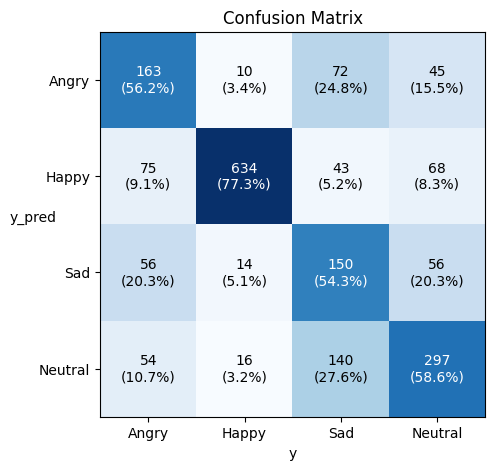

In [214]:
evaluate(trainer.model, torch_test[0], torch_test[1])

#### Weighted avg  

|구 분|정확도|정밀도|재현율|F1|
|---:|---:|---:|---:|---:|
|**No Sampling**|<span style="color:red">0.72|<span style="color:red">0.76|<span style="color:red">0.72|<span style="color:red">0.73|
|**SMOTE**|0.66|0.64|0.66|0.64|
|**ADASYN**|0.62|0.60|0.62|0.60|
|**SMOTE-diff**|0.66|0.64|0.66|0.64|

#### Macro avg  

|구 분|정확도|정밀도|재현율|F1|
|---:|---:|---:|---:|---:|
|**No Sampling**|<span style="color:red">0.72|<span style="color:red">0.64|<span style="color:red">0.66|<span style="color:red">0.63|
|**SMOTE**|0.66|0.61|0.60|0.60|
|**ADASYN**|0.62|0.57|0.57|0.56|
|**SMOTE-diff**|0.66|0.62|0.60|0.60|

## ADASYN - Different class ratio
- 최다 클래스(Happy)와 적용대상 클래스(Angry, Sad, Neutral) 차이의 절반만큼 추가로 증강

In [216]:
X_, y_ = preprocessing(
    X, y,
    test_ratio=.2,
    random_state=111,
    o_sampling='adasyn',
    u_sampling=None,
    **smote_args
)
train_data = (X_[0], y_[0])
test_data = (X_[1], y_[1])

Before: X((7571, 1296)), y((7571,))
Before Class: Counter({1: 3280, 3: 2028, 0: 1160, 2: 1103})
After Over Sampling: X((9848, 1296)), y((9848,))
After Over Sampling Class: Counter({1: 3280, 3: 2231, 0: 2226, 2: 2111})


### CNN

In [217]:
model = FERClassifier()

In [218]:
optimizer = optim.Adam(model.parameters())
crit = nn.NLLLoss(weight=torch.Tensor([1., 1., 1., 1.]), reduction='none')

In [219]:
torch_train = transform_tensor(train_data)
torch_test = transform_tensor(test_data)

In [220]:
trainer = Trainer(model, crit, optimizer)

In [221]:
trainer.train(torch_train, torch_test, epochs=epochs, batch_size=batch_size, early_stop=early_stop, figsize=None)

Epoch 1: train_loss=1.27782, valid_loss=0.90944, lowest_loss=0.90944
Epoch 2: train_loss=0.7898, valid_loss=0.82272, lowest_loss=0.82272
Epoch 3: train_loss=0.61703, valid_loss=0.84982, lowest_loss=0.82272
Epoch 4: train_loss=0.47385, valid_loss=0.89563, lowest_loss=0.82272
Epoch 5: train_loss=0.3703, valid_loss=0.89014, lowest_loss=0.82272
Epoch 6: train_loss=0.26668, valid_loss=1.15584, lowest_loss=0.82272
Early Stop at Epoch 7. Lowest Loss 0.82272 at 2 epoch
The best validstion loss from epoch=2, loss=0.82272



Classification Report
              precision    recall  f1-score   support

           0       0.42      0.55      0.48       224
           1       0.82      0.93      0.87       719
           2       0.61      0.32      0.42       526
           3       0.56      0.67      0.61       424

    accuracy                           0.66      1893
   macro avg       0.60      0.62      0.59      1893
weighted avg       0.65      0.66      0.64      1893



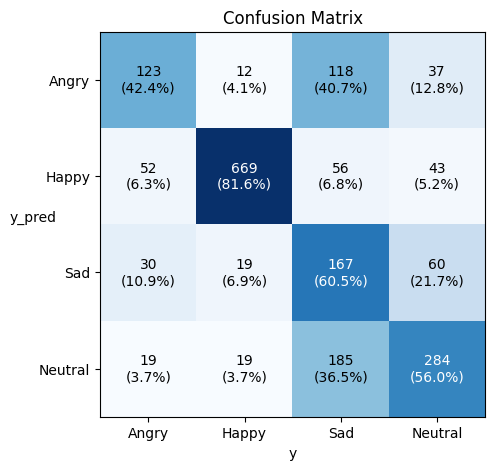

In [222]:
evaluate(trainer.model, torch_test[0], torch_test[1])

#### Weighted avg  

|구 분|정확도|정밀도|재현율|F1|
|---:|---:|---:|---:|---:|
|**No Sampling**|<span style="color:red">0.72|<span style="color:red">0.76|<span style="color:red">0.72|<span style="color:red">0.73|
|**SMOTE**|0.66|0.64|0.66|0.64|
|**ADASYN**|0.62|0.60|0.62|0.60|
|**SMOTE-diff**|0.66|0.64|0.66|0.64|
|**ADASYN-diff**|0.66|0.65|0.66|0.64|

#### Macro avg  

|구 분|정확도|정밀도|재현율|F1|
|---:|---:|---:|---:|---:|
|**No Sampling**|<span style="color:red">0.72|<span style="color:red">0.64|<span style="color:red">0.66|<span style="color:red">0.63|
|**SMOTE**|0.66|0.61|0.60|0.60|
|**ADASYN**|0.62|0.57|0.57|0.56|
|**SMOTE-diff**|0.66|0.62|0.60|0.60|
|**ADASYN-diff**|0.66|0.60|0.62|0.59|

## SMOTE + Tomek Links

In [223]:
smote_args = {}

X_, y_ = preprocessing(
    X, y,
    test_ratio=.2,
    random_state=111,
    o_sampling='smote',
    u_sampling='tomeklinks',
    **smote_args
)
train_data = (X_[0], y_[0])
test_data = (X_[1], y_[1])

Before: X((7571, 1296)), y((7571,))
Before Class: Counter({1: 3280, 3: 2028, 0: 1160, 2: 1103})
After Over Sampling: X((13120, 1296)), y((13120,))
After Over Sampling Class: Counter({1: 3280, 2: 3280, 3: 3280, 0: 3280})
After UnderSampling: X((13092, 1296)), y((13092,))
After UnderSampling Class: Counter({0: 3280, 2: 3277, 3: 3269, 1: 3266})


In [224]:
print('X_train Shape:', train_data[0].shape)
print('y_train Shape:', train_data[1].shape)
print('Class Distribution:', dict(sorted(Counter(train_data[1]).items(), key=lambda x:x[0])))
print()
print('X_test Shape:', test_data[0].shape)
print('y_test Shape:', test_data[1].shape)
print('Class Distribution:', dict(sorted(Counter(test_data[1]).items(), key=lambda x:x[0])))

X_train Shape: (13092, 36, 36)
y_train Shape: (13092,)
Class Distribution: {0: 3280, 1: 3266, 2: 3277, 3: 3269}

X_test Shape: (1893, 36, 36)
y_test Shape: (1893,)
Class Distribution: {0: 290, 1: 820, 2: 276, 3: 507}


### CNN

In [243]:
model = FERClassifier()

In [244]:
optimizer = optim.Adam(model.parameters())
crit = nn.NLLLoss(weight=torch.Tensor([1., 1., 1., 1.]), reduction='none')

In [245]:
torch_train = transform_tensor(train_data)
torch_test = transform_tensor(test_data)

In [246]:
trainer = Trainer(model, crit, optimizer)

In [247]:
trainer.train(torch_train, torch_test, epochs=epochs, batch_size=batch_size, early_stop=early_stop,figsize=None)

Epoch 1: train_loss=1.14078, valid_loss=0.96769, lowest_loss=0.96769
Epoch 2: train_loss=0.69593, valid_loss=0.89967, lowest_loss=0.89967
Epoch 3: train_loss=0.50226, valid_loss=1.14665, lowest_loss=0.89967
Epoch 4: train_loss=0.36761, valid_loss=1.10717, lowest_loss=0.89967
Epoch 5: train_loss=0.2876, valid_loss=1.45848, lowest_loss=0.89967
Epoch 6: train_loss=0.20281, valid_loss=1.69748, lowest_loss=0.89967
Early Stop at Epoch 7. Lowest Loss 0.89967 at 2 epoch
The best validstion loss from epoch=2, loss=0.89967



Classification Report
              precision    recall  f1-score   support

           0       0.52      0.44      0.48       342
           1       0.76      0.94      0.84       662
           2       0.56      0.36      0.44       427
           3       0.58      0.64      0.61       462

    accuracy                           0.64      1893
   macro avg       0.60      0.59      0.59      1893
weighted avg       0.63      0.64      0.63      1893



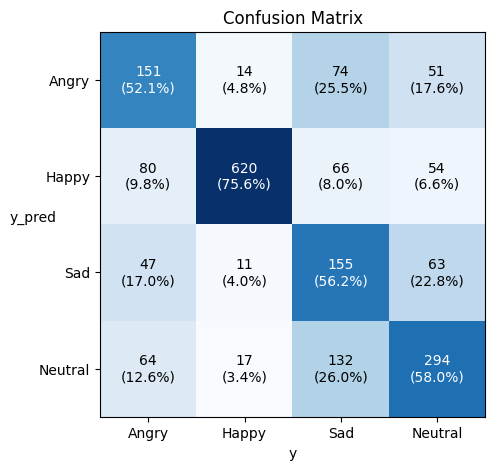

In [248]:
evaluate(trainer.model, torch_test[0], torch_test[1])

#### Weighted avg  

|구 분|정확도|정밀도|재현율|F1|
|---:|---:|---:|---:|---:|
|**No Sampling**|<span style="color:red">0.72|<span style="color:red">0.76|<span style="color:red">0.72|<span style="color:red">0.73|
|**SMOTE**|0.66|0.64|0.66|0.64|
|**ADASYN**|0.62|0.60|0.62|0.60|
|**SMOTE-diff**|0.66|0.64|0.66|0.64|
|**ADASYN-diff**|0.66|0.65|0.66|0.64|
|**SMOTE+Tomeklinks**|0.64|0.63|0.64|0.63|

#### Macro avg  

|구 분|정확도|정밀도|재현율|F1|
|---:|---:|---:|---:|---:|
|**No Sampling**|<span style="color:red">0.72|<span style="color:red">0.64|<span style="color:red">0.66|<span style="color:red">0.63|
|**SMOTE**|0.66|0.61|0.60|0.60|
|**ADASYN**|0.62|0.57|0.57|0.56|
|**SMOTE-diff**|0.66|0.62|0.60|0.60|
|**SMOTE+Tomeklinks**|0.64|0.60|0.59|0.59|

## ADASYN + Tomek Links

In [249]:
smote_args = {}

X_, y_ = preprocessing(
    X, y,
    test_ratio=.2,
    random_state=111,
    o_sampling='adasyn',
    u_sampling='tomeklinks',
    **smote_args
)
train_data = (X_[0], y_[0])
test_data = (X_[1], y_[1])

Before: X((7571, 1296)), y((7571,))
Before Class: Counter({1: 3280, 3: 2028, 0: 1160, 2: 1103})
After Over Sampling: X((12699, 1296)), y((12699,))
After Over Sampling Class: Counter({1: 3280, 3: 3279, 0: 3152, 2: 2988})
After UnderSampling: X((12679, 1296)), y((12679,))
After UnderSampling Class: Counter({1: 3273, 3: 3269, 0: 3149, 2: 2988})


In [250]:
print('X_train Shape:', train_data[0].shape)
print('y_train Shape:', train_data[1].shape)
print('Class Distribution:', dict(sorted(Counter(train_data[1]).items(), key=lambda x:x[0])))
print()
print('X_test Shape:', test_data[0].shape)
print('y_test Shape:', test_data[1].shape)
print('Class Distribution:', dict(sorted(Counter(test_data[1]).items(), key=lambda x:x[0])))

X_train Shape: (12679, 36, 36)
y_train Shape: (12679,)
Class Distribution: {0: 3149, 1: 3273, 2: 2988, 3: 3269}

X_test Shape: (1893, 36, 36)
y_test Shape: (1893,)
Class Distribution: {0: 290, 1: 820, 2: 276, 3: 507}


### CNN

In [251]:
model = FERClassifier()

In [252]:
optimizer = optim.Adam(model.parameters())
crit = nn.NLLLoss(weight=torch.Tensor([1., 1., 1., 1.]), reduction='none')

In [253]:
torch_train = transform_tensor(train_data)
torch_test = transform_tensor(test_data)

In [254]:
trainer = Trainer(model, crit, optimizer)

In [255]:
trainer.train(torch_train, torch_test, epochs=epochs, batch_size=batch_size, early_stop=early_stop, figsize=None)

Epoch 1: train_loss=1.3064, valid_loss=1.06423, lowest_loss=1.06423
Epoch 2: train_loss=0.91135, valid_loss=0.90133, lowest_loss=0.90133
Epoch 3: train_loss=0.67086, valid_loss=1.01366, lowest_loss=0.90133
Epoch 4: train_loss=0.48108, valid_loss=1.01987, lowest_loss=0.90133
Epoch 5: train_loss=0.34073, valid_loss=1.15353, lowest_loss=0.90133
Epoch 6: train_loss=0.24294, valid_loss=1.34863, lowest_loss=0.90133
Early Stop at Epoch 7. Lowest Loss 0.90133 at 2 epoch
The best validstion loss from epoch=2, loss=0.90133



Classification Report
              precision    recall  f1-score   support

           0       0.59      0.39      0.47       431
           1       0.75      0.94      0.84       656
           2       0.35      0.34      0.35       283
           3       0.66      0.64      0.65       523

    accuracy                           0.64      1893
   macro avg       0.59      0.58      0.58      1893
weighted avg       0.63      0.64      0.63      1893



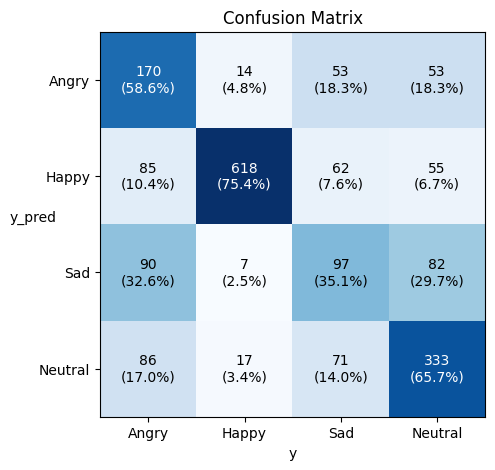

In [256]:
evaluate(trainer.model, torch_test[0], torch_test[1])

#### Weighted avg  

|구 분|정확도|정밀도|재현율|F1|
|---:|---:|---:|---:|---:|
|**No Sampling**|<span style="color:red">0.72|<span style="color:red">0.76|<span style="color:red">0.72|<span style="color:red">0.73|
|**SMOTE**|0.66|0.64|0.66|0.64|
|**ADASYN**|0.62|0.60|0.62|0.60|
|**SMOTE-diff**|0.66|0.64|0.66|0.64|
|**ADASYN-diff**|0.66|0.65|0.66|0.64|
|**SMOTE+Tomeklinks**|0.64|0.63|0.64|0.63|
|**ADASYN+Tomeklinks**|0.64|0.63|0.64|0.63|

#### Macro avg  

|구 분|정확도|정밀도|재현율|F1|
|---:|---:|---:|---:|---:|
|**No Sampling**|<span style="color:red">0.72|<span style="color:red">0.64|<span style="color:red">0.66|<span style="color:red">0.63|
|**SMOTE**|0.66|0.61|0.60|0.60|
|**ADASYN**|0.62|0.57|0.57|0.56|
|**SMOTE-diff**|0.66|0.62|0.60|0.60|
|**SMOTE+Tomeklinks**|0.64|0.60|0.59|0.59|
|**ADASYN+Tomeklinks**|0.64|0.59|0.58|0.58|

## SMOTE - Diff + TomekLinks

In [257]:
def oversample_criterion(v, max_v, over_ratio=.5):
    return v + int((max_v - v) * over_ratio)

In [258]:
train_ratio = .8
cls_cnt = sorted(Counter(y).items(), key=lambda x: x[1])
max_cls_cnt = cls_cnt[-1][-1]
cls_cnt

[(2, 1379), (0, 1450), (3, 2535), (1, 4100)]

In [259]:
smote_args = {
    "sampling_strategy": {
        k:oversample_criterion(int(v * train_ratio), int(max_cls_cnt * train_ratio))
        for k, v in cls_cnt
    }
}
smote_args

{'sampling_strategy': {2: 2191, 0: 2220, 3: 2654, 1: 3280}}

In [260]:
X_, y_ = preprocessing(
    X, y,
    test_ratio=.2,
    random_state=111,
    o_sampling='smote',
    u_sampling='tomeklinks',
    **smote_args
)
train_data = (X_[0], y_[0])
test_data = (X_[1], y_[1])

Before: X((7571, 1296)), y((7571,))
Before Class: Counter({1: 3280, 3: 2028, 0: 1160, 2: 1103})
After Over Sampling: X((10345, 1296)), y((10345,))
After Over Sampling Class: Counter({1: 3280, 3: 2654, 0: 2220, 2: 2191})
After UnderSampling: X((10289, 1296)), y((10289,))
After UnderSampling Class: Counter({1: 3256, 3: 2630, 0: 2212, 2: 2191})


### CNN

In [267]:
model = FERClassifier()

In [268]:
optimizer = optim.Adam(model.parameters())
crit = nn.NLLLoss(weight=torch.Tensor([1., 1., 1., 1.]), reduction='none')

In [269]:
torch_train = transform_tensor(train_data)
torch_test = transform_tensor(test_data)

In [270]:
trainer = Trainer(model, crit, optimizer)

In [271]:
trainer.train(torch_train, torch_test, epochs=epochs, batch_size=batch_size, early_stop=early_stop,figsize=None)

Epoch 1: train_loss=1.22445, valid_loss=0.89625, lowest_loss=0.89625
Epoch 2: train_loss=0.77715, valid_loss=0.93162, lowest_loss=0.89625
Epoch 3: train_loss=0.60825, valid_loss=0.82635, lowest_loss=0.82635
Epoch 4: train_loss=0.5014, valid_loss=0.96991, lowest_loss=0.82635
Epoch 5: train_loss=0.38697, valid_loss=0.95124, lowest_loss=0.82635
Epoch 6: train_loss=0.28141, valid_loss=1.18978, lowest_loss=0.82635
Epoch 7: train_loss=0.23571, valid_loss=1.51683, lowest_loss=0.82635
Early Stop at Epoch 8. Lowest Loss 0.82635 at 3 epoch
The best validstion loss from epoch=3, loss=0.82635



Classification Report
              precision    recall  f1-score   support

           0       0.50      0.54      0.52       267
           1       0.85      0.90      0.88       780
           2       0.59      0.41      0.48       399
           3       0.59      0.67      0.63       447

    accuracy                           0.69      1893
   macro avg       0.63      0.63      0.63      1893
weighted avg       0.69      0.69      0.68      1893



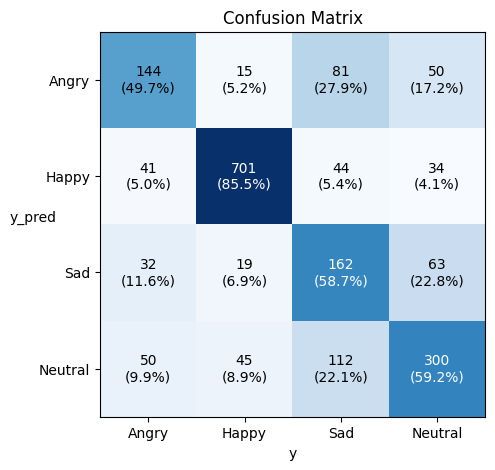

In [272]:
evaluate(trainer.model, torch_test[0], torch_test[1])

#### Weighted avg  

|구 분|정확도|정밀도|재현율|F1|
|---:|---:|---:|---:|---:|
|**No Sampling**|<span style="color:red">0.72|<span style="color:red">0.76|<span style="color:red">0.72|<span style="color:red">0.73|
|**SMOTE**|0.66|0.64|0.66|0.64|
|**ADASYN**|0.62|0.60|0.62|0.60|
|**SMOTE-diff**|0.66|0.64|0.66|0.64|
|**ADASYN-diff**|0.66|0.65|0.66|0.64|
|**SMOTE+Tomeklinks**|0.64|0.63|0.64|0.63|
|**ADASYN+Tomeklinks**|0.64|0.63|0.64|0.63|
|**SMOTE-diff+Tomeklinks**|0.69|0.69|0.69|0.68|

#### Macro avg  

|구 분|정확도|정밀도|재현율|F1|
|---:|---:|---:|---:|---:|
|**No Sampling**|<span style="color:red">0.72|<span style="color:red">0.64|<span style="color:red">0.66|<span style="color:red">0.63|
|**SMOTE**|0.66|0.61|0.60|0.60|
|**ADASYN**|0.62|0.57|0.57|0.56|
|**SMOTE-diff**|0.66|0.62|0.60|0.60|
|**SMOTE+Tomeklinks**|0.64|0.60|0.59|0.59|
|**ADASYN+Tomeklinks**|0.64|0.59|0.58|0.58|
|**SMOTE-diff+Tomeklinks**|0.69|0.63|0.63|<span style="color:red">0.63|

## ADASYN - Diff + TomekLinks

In [273]:
smote_args = {
    "sampling_strategy": {
        k:oversample_criterion(int(v * train_ratio), int(max_cls_cnt * train_ratio))
        for k, v in cls_cnt
    }
}
smote_args

{'sampling_strategy': {2: 2191, 0: 2220, 3: 2654, 1: 3280}}

In [274]:
X_, y_ = preprocessing(
    X, y,
    test_ratio=.2,
    random_state=111,
    o_sampling='adasyn',
    u_sampling='tomeklinks',
    **smote_args
)
train_data = (X_[0], y_[0])
test_data = (X_[1], y_[1])

Before: X((7571, 1296)), y((7571,))
Before Class: Counter({1: 3280, 3: 2028, 0: 1160, 2: 1103})
After Over Sampling: X((9848, 1296)), y((9848,))
After Over Sampling Class: Counter({1: 3280, 3: 2231, 0: 2226, 2: 2111})
After UnderSampling: X((9775, 1296)), y((9775,))
After UnderSampling Class: Counter({1: 3248, 0: 2222, 3: 2194, 2: 2111})


### CNN

In [281]:
model = FERClassifier()

In [282]:
optimizer = optim.Adam(model.parameters())
crit = nn.NLLLoss(weight=torch.Tensor([1., 1., 1., 1.]), reduction='none')

In [283]:
torch_train = transform_tensor(train_data)
torch_test = transform_tensor(test_data)

In [284]:
trainer = Trainer(model, crit, optimizer)

In [285]:
trainer.train(torch_train, torch_test, epochs=epochs, batch_size=batch_size, early_stop=early_stop,figsize=None)

Epoch 1: train_loss=1.28914, valid_loss=0.95856, lowest_loss=0.95856
Epoch 2: train_loss=0.88384, valid_loss=0.85793, lowest_loss=0.85793
Epoch 3: train_loss=0.71478, valid_loss=0.88908, lowest_loss=0.85793
Epoch 4: train_loss=0.60367, valid_loss=0.9002, lowest_loss=0.85793
Epoch 5: train_loss=0.55298, valid_loss=0.98512, lowest_loss=0.85793
Epoch 6: train_loss=0.46698, valid_loss=0.96902, lowest_loss=0.85793
Early Stop at Epoch 7. Lowest Loss 0.85793 at 2 epoch
The best validstion loss from epoch=2, loss=0.85793



Classification Report
              precision    recall  f1-score   support

           0       0.26      0.52      0.35       145
           1       0.86      0.85      0.85       832
           2       0.59      0.30      0.40       536
           3       0.53      0.70      0.60       380

    accuracy                           0.64      1893
   macro avg       0.56      0.59      0.55      1893
weighted avg       0.67      0.64      0.64      1893



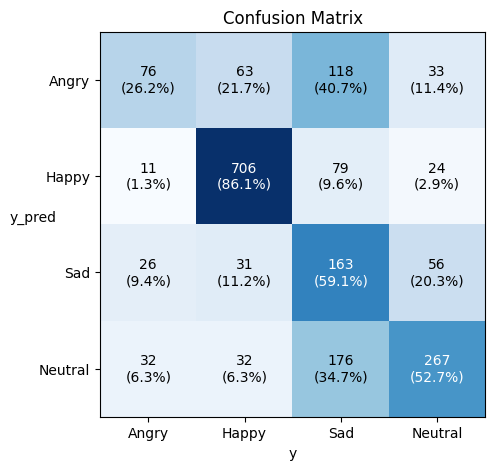

In [286]:
evaluate(trainer.model, torch_test[0], torch_test[1])

#### Weighted avg  

|구 분|정확도|정밀도|재현율|F1|
|---:|---:|---:|---:|---:|
|**No Sampling**|<span style="color:red">0.72|<span style="color:red">0.76|<span style="color:red">0.72|<span style="color:red">0.73|
|**SMOTE**|0.66|0.64|0.66|0.64|
|**ADASYN**|0.62|0.60|0.62|0.60|
|**SMOTE-diff**|0.66|0.64|0.66|0.64|
|**ADASYN-diff**|0.66|0.65|0.66|0.64|
|**SMOTE+Tomeklinks**|0.64|0.63|0.64|0.63|
|**ADASYN+Tomeklinks**|0.64|0.63|0.64|0.63|
|**SMOTE-diff+Tomeklinks**|0.69|0.69|0.69|0.68|
|**ADASYN-diff+Tomeklinks**|0.64|0.67|0.64|0.64|


#### Macro avg  

|구 분|정확도|정밀도|재현율|F1|
|---:|---:|---:|---:|---:|
|**No Sampling**|<span style="color:red">0.72|<span style="color:red">0.64|<span style="color:red">0.66|<span style="color:red">0.63|
|**SMOTE**|0.66|0.61|0.60|0.60|
|**ADASYN**|0.62|0.57|0.57|0.56|
|**SMOTE-diff**|0.66|0.62|0.60|0.60|
|**SMOTE+Tomeklinks**|0.64|0.60|0.59|0.59|
|**ADASYN+Tomeklinks**|0.64|0.59|0.58|0.58|
|**SMOTE-diff+Tomeklinks**|0.69|0.63|0.63|<span style="color:red">0.63|
|**ADASYN-diff+Tomeklinks**|0.64|0.56|0.59|0.55|

## SMOTE - Diff + TomekLinks + Loss Weight 조절
- 가장 F1 Score가 낮은 Sad에 가중치 10% 추가

In [370]:
def oversample_criterion(v, max_v, over_ratio=.5):
    return v + int((max_v - v) * over_ratio)

In [371]:
train_ratio = .8
cls_cnt = sorted(Counter(y).items(), key=lambda x: x[1])
max_cls_cnt = cls_cnt[-1][-1]
cls_cnt

[(2, 1379), (0, 1450), (3, 2535), (1, 4100)]

In [372]:
smote_args = {
    "sampling_strategy": {
        k:oversample_criterion(int(v * train_ratio), int(max_cls_cnt * train_ratio))
        for k, v in cls_cnt
    }
}
smote_args

{'sampling_strategy': {2: 2191, 0: 2220, 3: 2654, 1: 3280}}

In [373]:
X_, y_ = preprocessing(
    X, y,
    test_ratio=.2,
    random_state=111,
    o_sampling='smote',
    u_sampling='tomeklinks',
    **smote_args
)
train_data = (X_[0], y_[0])
test_data = (X_[1], y_[1])

Before: X((7571, 1296)), y((7571,))
Before Class: Counter({1: 3280, 3: 2028, 0: 1160, 2: 1103})
After Over Sampling: X((10345, 1296)), y((10345,))
After Over Sampling Class: Counter({1: 3280, 3: 2654, 0: 2220, 2: 2191})
After UnderSampling: X((10292, 1296)), y((10292,))
After UnderSampling Class: Counter({1: 3257, 3: 2633, 0: 2211, 2: 2191})


### CNN

In [374]:
model = FERClassifier()

In [375]:
optimizer = optim.Adam(model.parameters())
crit = nn.NLLLoss(weight=torch.Tensor([1.1, 1., 1.1, 1.]), reduction='none')

In [376]:
torch_train = transform_tensor(train_data)
torch_test = transform_tensor(test_data)

In [377]:
trainer = Trainer(model, crit, optimizer)

Epoch 1: train_loss=1.28099, valid_loss=0.99004, lowest_loss=0.99004
Epoch 2: train_loss=0.91672, valid_loss=0.88042, lowest_loss=0.88042
Epoch 3: train_loss=0.72353, valid_loss=0.864, lowest_loss=0.864
Epoch 4: train_loss=0.56911, valid_loss=0.90573, lowest_loss=0.864
Epoch 5: train_loss=0.48498, valid_loss=1.08239, lowest_loss=0.864
Epoch 6: train_loss=0.76219, valid_loss=0.91631, lowest_loss=0.864
Epoch 7: train_loss=0.50991, valid_loss=0.95804, lowest_loss=0.864
Early Stop at Epoch 8. Lowest Loss 0.864 at 3 epoch
The best validstion loss from epoch=3, loss=0.864


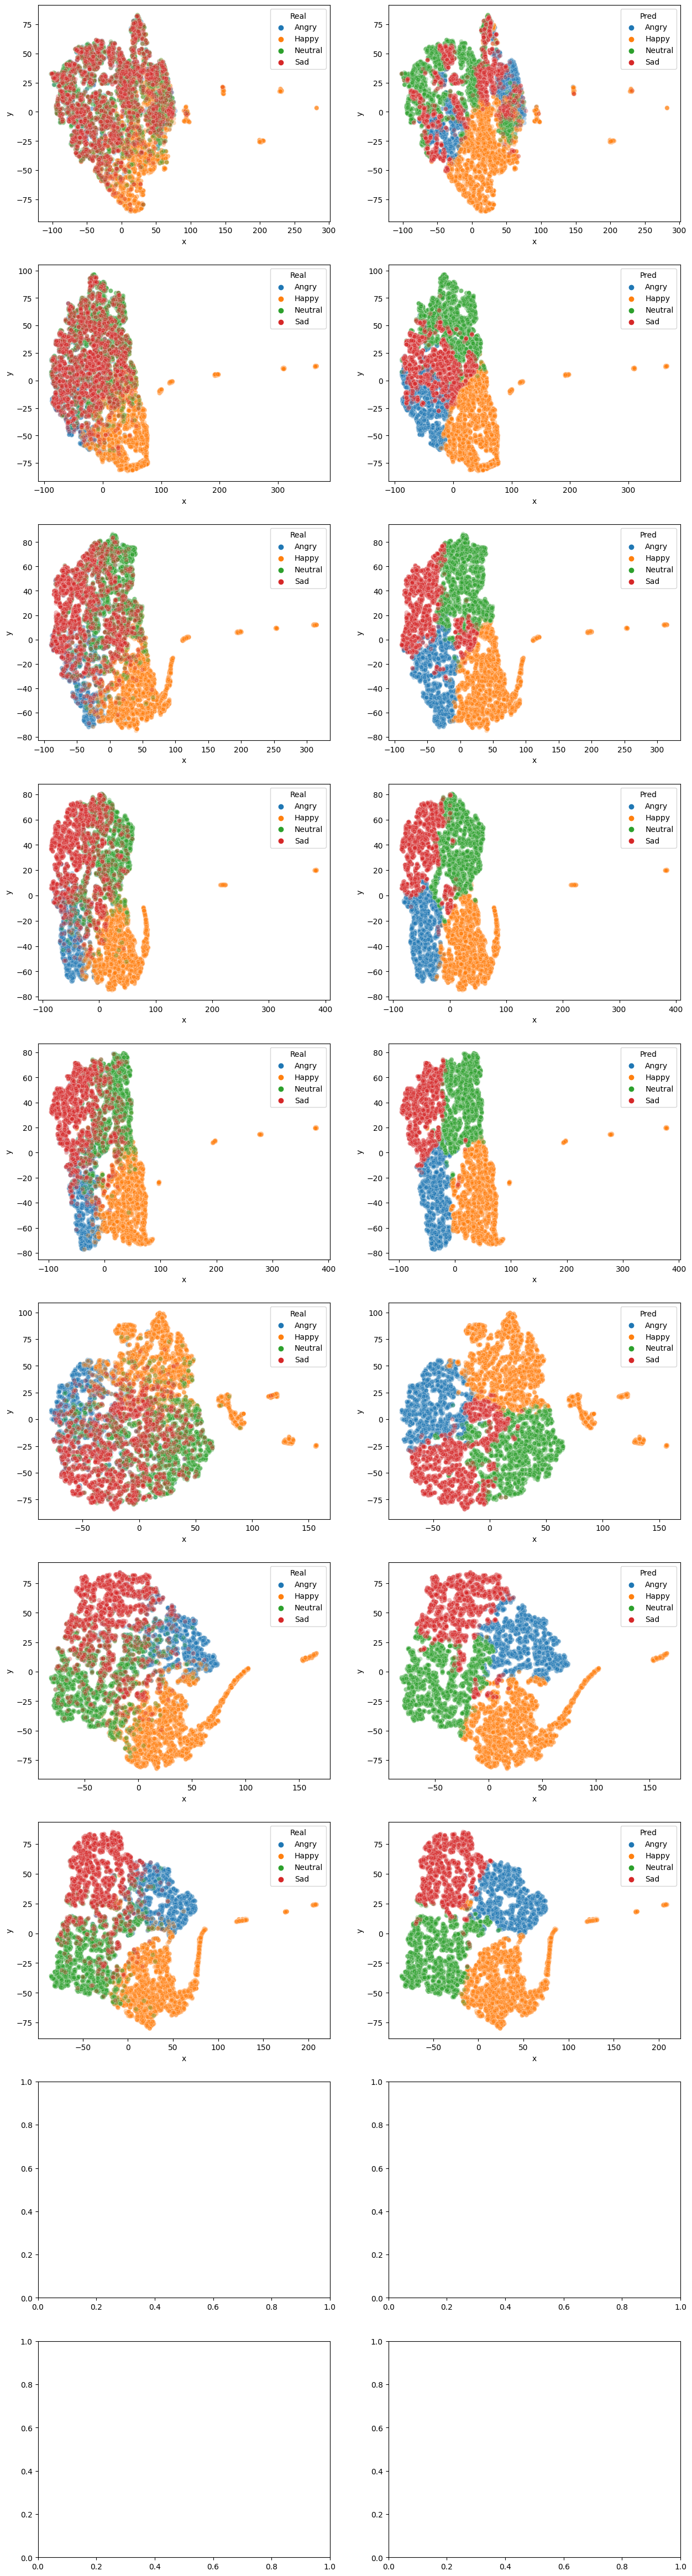

In [378]:
trainer.train(torch_train, torch_test, epochs=epochs, batch_size=batch_size, early_stop=early_stop, figsize=(15, 60))


Classification Report
              precision    recall  f1-score   support

           0       0.53      0.53      0.53       293
           1       0.80      0.94      0.86       690
           2       0.57      0.38      0.46       408
           3       0.64      0.64      0.64       502

    accuracy                           0.68      1893
   macro avg       0.63      0.62      0.62      1893
weighted avg       0.66      0.68      0.67      1893



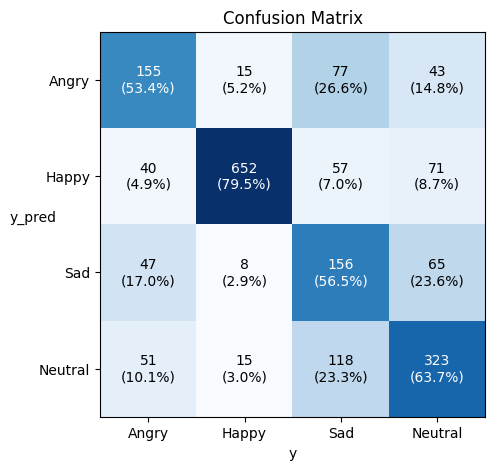

In [379]:
evaluate(trainer.model, torch_test[0], torch_test[1])

#### Weighted avg  

|구 분|정확도|정밀도|재현율|F1|
|---:|---:|---:|---:|---:|
|**No Sampling**|<span style="color:red">0.72|<span style="color:red">0.76|<span style="color:red">0.72|<span style="color:red">0.73|
|**SMOTE**|0.66|0.64|0.66|0.64|
|**ADASYN**|0.62|0.60|0.62|0.60|
|**SMOTE-diff**|0.66|0.64|0.66|0.64|
|**ADASYN-diff**|0.66|0.65|0.66|0.64|
|**SMOTE+Tomeklinks**|0.64|0.63|0.64|0.63|
|**ADASYN+Tomeklinks**|0.64|0.63|0.64|0.63|
|**SMOTE-diff+Tomeklinks**|0.69|0.69|0.69|0.68|
|**ADASYN-diff+Tomeklinks**|0.64|0.67|0.64|0.64|
|**SMOTE-diff+Tomeklinks+LossWeight**|0.68|0.66|0.68|0.67|


#### Macro avg  

|구 분|정확도|정밀도|재현율|F1|
|---:|---:|---:|---:|---:|
|**No Sampling**|<span style="color:red">0.72|<span style="color:red">0.64|<span style="color:red">0.66|<span style="color:red">0.63|
|**SMOTE**|0.66|0.61|0.60|0.60|
|**ADASYN**|0.62|0.57|0.57|0.56|
|**SMOTE-diff**|0.66|0.62|0.60|0.60|
|**SMOTE+Tomeklinks**|0.64|0.60|0.59|0.59|
|**ADASYN+Tomeklinks**|0.64|0.59|0.58|0.58|
|**SMOTE-diff+Tomeklinks**|0.69|0.63|0.63|<span style="color:red">0.63|
|**ADASYN-diff+Tomeklinks**|0.64|0.56|0.59|0.55|
|**SMOTE-diff+Tomeklinks+LossWeight**|0.68|0.63|0.62|0.62|

## Baseline VS SMOTE Diff Class + TOMEKLINKS + Loss Weight Adjust

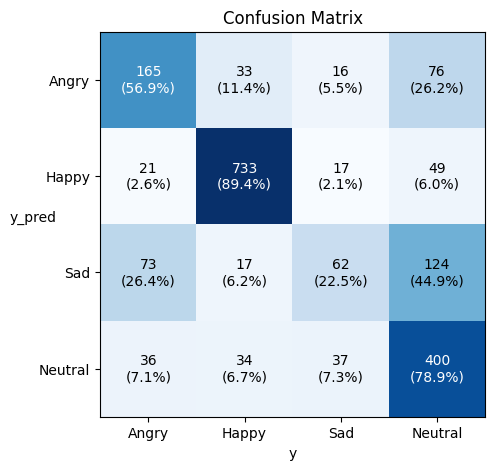

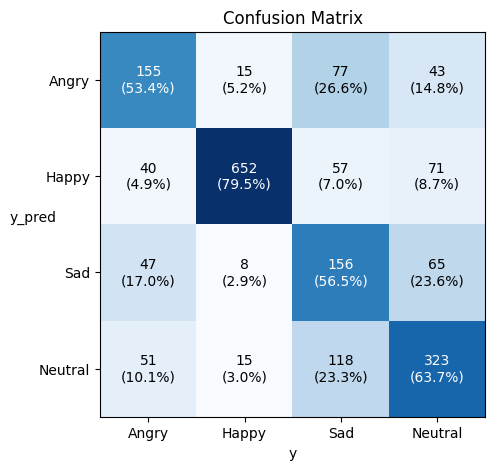